In [1]:
import gc
import os
import time
import datetime
from dateutil import relativedelta
from tqdm.notebook import tqdm
import numpy as np
import talib
from talib import MA_Type
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
# path_price = './stock/au/price/price/'
path_price = './price_au_web/'
list_file_price = [os.path.join(path_price, filename) for filename in os.listdir(path_price) if os.path.isfile(os.path.join(path_price, filename))]

# DataLoader

In [3]:
def make_label(df, dropna=False, stock=None):
    list_stock = df['symbol'].unique().tolist()
    if len(list_stock) > 1:
        raise ValueError('There are more than one stock in this file', stock) 
    if len(list_stock) < 1:
        raise ValueError('There are no stock in this file', stock) 
    if stock != list_stock[0]:
        raise ValueError(f'The stock value is not match: value "{list_stock[0]}" vs "{stock}"')
    
    if dropna:
        df.dropna(inplace=True)
        
    if df.groupby('Date').size().reset_index(name='count').query('count > 1').shape[0] > 0:
        raise ValueError(f'The stock value is duplicate: "{stock}"')
        
    df = df.sort_values(by='Date', ascending=True)
    
    for lag in list(range(1, 3+1)):
        df['tmp'] = df['Adj Close'].pct_change(periods=lag).shift(-lag)
        df[f'label_next{lag}'] = (df['tmp'] >= 0.01).astype('int')
        del df['tmp']

    df['adjClose_next10_max'] = df.groupby('symbol')['Adj Close'].transform(lambda x: x.rolling(10).max().shift(-10))
    df['label_next10_max'] = (df['adjClose_next10_max'] / df['Adj Close'] - 1 >= 0.01).astype('int')
    
    df['adjClose_next3to10_max'] = df.groupby('symbol')['Adj Close'].transform(lambda x: x.rolling(7).max().shift(-9))
    df['label_next3to10_max'] = (df['adjClose_next3to10_max'] / df['Adj Close'] - 1 >= 0.01).astype('int')
    
    return df
        
def make_pct_change(df):
    df = df.sort_values(by='Date', ascending=True)
    
    for lag_day in list(range(1, 16)) + [20, 30, 40]:
        df[f'pct_change_price_lag{lag_day}'] = df['Adj Close'].pct_change(lag_day)
    
    return df

def make_ext_features(df):
    df = df.sort_values(by='Date', ascending=True)
    
    df['ext_feat_OpenClose'] = df['Close'] / df['Open'] - 1
    df['ext_feat_upOrDownInDay'] = (df['ext_feat_OpenClose'] > 0).astype('int')
    
    df['ext_feat_OpenHigh'] = df['High'] / df['Open'] - 1
    df['ext_feat_OpenLow'] = df['Low'] / df['Open'] - 1
    
    df['ext_feat_CloseHigh'] = df['High'] / df['Close'] - 1
    df['ext_feat_CloseLow'] = df['Low'] / df['Close'] - 1
    
    df['ext_feat_HighLow'] = df['High'] / df['Low'] - 1
    
    for lag_day in [5, 10, 20, 30]:
        df[f'ext_feat_countUpDays_{lag_day}'] = df['ext_feat_upOrDownInDay'].rolling(lag_day).sum()

    return df
        
def make_technical_features(df, dropna=False, num_lag=10):
    if dropna:
        df.dropna(inplace=True)
        
    df = df.sort_values(by='Date', ascending=True)
    
    for timeperiod in [20, 50]:
        df[f'ta_SMA{timeperiod}'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.SMA(x, timeperiod=timeperiod)) 

    for timeperiod in [20, 50]:
        df[f'ta_EMA{timeperiod}'] = df.groupby('symbol')['Adj Close'].transform(lambda x: talib.EMA(x, timeperiod=timeperiod)) 

    upper, middle, lower = talib.BBANDS(df['Adj Close'], timeperiod=5, matype=MA_Type.T3)
    df['ta_BBANDS_upper'] = upper
    df['ta_BBANDS_middle'] = middle
    df['ta_BBANDS_lower'] = lower
    
#     macd, macdsignal, macdhist = talib.MACD(df['Adj Close'])
#     df['ta_MACD_macd'] = macd
#     df['ta_MACD_macdsignal'] = macdsignal
#     df['ta_MACD_macdhist'] = macdhist

    df['ta_RSI'] = talib.RSI(df['Adj Close'], timeperiod=14)
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_RSI_lag{lag_day}'] = df['ta_RSI'].shift(lag_day)
    
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'])
    df['ta_STOCH_slowk'] = slowk
    df['ta_STOCH_slowd'] = slowd
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_STOCH_slowk_lag{lag_day}'] = df['ta_STOCH_slowk'].shift(lag_day)
#         df[f'ta_STOCH_slowd_lag{lag_day}'] = df['ta_STOCH_slowd'].shift(lag_day)

    df['ta_MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'])
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_MFI_lag{lag_day}'] = df['ta_MFI'].shift(lag_day)

    df['ta_OBV'] = talib.OBV(df['Adj Close'], df['Volume'])
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_OBV_lag{lag_day}'] = df['ta_OBV'].shift(lag_day)
        
    df['ta_AD'] = talib.AD(df['High'], df['Low'], df['Close'], df['Volume'])
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_AD_lag{lag_day}'] = df['ta_AD'].shift(lag_day)

#     df['ta_MINUS_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'])
#     df['ta_PLUS_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'])
#     for lag_day in list(range(1, num_lag+1)):        
#         df[f'ta_MINUS_DI_lag{lag_day}'] = df['ta_MINUS_DI'].shift(lag_day)
#         df[f'ta_PLUS_DI_lag{lag_day}'] = df['ta_PLUS_DI'].shift(lag_day)
        
#     df['ta_DI_uptrend'] = (df['ta_PLUS_DI'] > df['ta_MINUS_DI']).astype('int')
#     df['ta_DI_downtrend'] = (df['ta_PLUS_DI'] < df['ta_MINUS_DI']).astype('int')

    df['ta_ADX'] = talib.ADX(df['High'], df['Low'], df['Close'])
#     df['ta_ADX_over25'] = (df['ta_ADX'] > 25).astype('int')
#     df['ta_ADX_uptrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] > df['ta_MINUS_DI'])).astype('int')
#     df['ta_ADX_downtrend'] = ((df['ta_ADX'] > 25) & (df['ta_PLUS_DI'] < df['ta_MINUS_DI'])).astype('int')

#     df['ta_WILLR'] = talib.WILLR(df['High'], df['Low'], df['Close'])
#     df['ta_WILLR_overbought'] = (df['ta_WILLR'] >= -20).astype('int')
#     df['ta_WILLR_oversold'] = (df['ta_WILLR'] <= -80).astype('int')

#     df['ta_CCI'] = talib.CCI(df['High'], df['Low'], df['Close'])
#     df['ta_CCI_overbought'] = (df['ta_CCI'] >= 100).astype('int')
#     df['ta_CCI_oversold'] = (df['ta_CCI'] <= -100).astype('int')

    df['ta_ATR'] = talib.ATR(df['High'], df['Low'], df['Close'])

#     df['ta_ULTOSC'] = talib.ULTOSC(df['High'], df['Low'], df['Close'])
#     df['ta_ULTOSC_overbought'] = (df['ta_ULTOSC'] >= 70).astype('int')
#     df['ta_ULTOSC_oversold'] = (df['ta_ULTOSC'] <= 30).astype('int')
#     df['ta_ULTOSC_upperPart'] = (df['ta_ULTOSC'] >= 50).astype('int')

    df['ta_ROC'] = talib.ROC(df['Adj Close'], timeperiod=10)
#     df['ta_ROC_higherPart'] = (df['ta_ROC'] >= 0).astype('int')
    
#     aroondown, aroonup = talib.AROON(df['High'], df['Low'])
#     df['ta_AROON_aroondown'] = aroondown
#     df['ta_AROON_aroonup'] = aroonup
#     df['ta_AROON_aroonup_uptrend'] = (df['ta_AROON_aroonup'] >= 70).astype('int')
#     df['ta_AROON_aroonup_downtrend'] = (df['ta_AROON_aroonup'] <= 30).astype('int')
#     df['ta_AROON_aroondown_downtrend'] = (df['ta_AROON_aroondown'] >= 70).astype('int')
#     df['ta_AROON_aroondown_uptrend'] = (df['ta_AROON_aroondown'] <= 30).astype('int')
#     df['ta_AROON_aroonup_over_aroondown'] = (df['ta_AROON_aroonup'] >= df['ta_AROON_aroondown']).astype('int')

    return df

In [4]:
list200asx = pd.read_csv('list_asx200.csv')['symbol'].unique().tolist()

In [5]:
def get_sector(symbol):
    info = yf.Ticker(symbol)
    if 'sector' in info.info:
        return info.info['sector']
    return None

# get_sector('AAPL')

KeyboardInterrupt: 

In [6]:
if os.path.isfile('au_symbol_sector.csv'):
    df_sector = pd.read_csv('au_symbol_sector.csv')
else:
    dict_symbol = {}
    for symbol in tqdm(list200asx):
        sector =  get_sector(symbol + '.AX')
        dict_symbol[symbol] = sector

        if sector is None:
            print(f'{symbol}: sector is None')
    
    df_sector = pd.DataFrame([list(dict_symbol.keys()), list(dict_symbol.values())]).T
    df_sector.columns = ['symbol', 'sector']
    df_sector.to_csv('au_symbol_sector.csv', index=False)

In [7]:
df = None
filter_start_time = '2008-01-01'
filter_end_time = None
# select_col = ['Date', 'symbol', 
#               'Open', 'High', 'Low', 'Close', 
#               'Adj Close', 'Volume', 
#               'Dividends', 'Stock Splits', 'sector', 'country', 'exchange']

for file in tqdm(list_file_price):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    
    if file_extension != '.csv':
        continue
    
    symbol = file_name.split('.')[0]
    
    if symbol not in list200asx:
        continue
    
    df_price = pd.read_csv(file)#[select_col]
    
    df_price['symbol'] = symbol
    
    df_price = df_price[df_price['Volume'] > 0]
    
    df_price['Date'] = pd.to_datetime(df_price['Date'])
    
    min_date = df_price['Date'].min()
    if min_date >= pd.to_datetime('2017-01-01'):
        print(f'ignored {file_name} since the min_date is {min_date}')
        continue
    
    df_price = df_price[df_price['Date'] >= filter_start_time]
    if filter_end_time is not None:
        df_price = df_price[df_price['Date'] <= filter_end_time]
        
    if len(df_price) <= 300:
        continue
    
    df_price = df_price.merge(df_sector, on='symbol', how='left')
    df_price = make_label(df_price, dropna=True, stock=symbol)
#     try:
#         df_price = get_info(df_price, stock=file_name)
#     except:
#         print(f'failed to get stock info {file_name}. Retrying with yahoo service...')
#         df_price = get_info(df_price, stock=file_name, get_info='yahoo')
        
    df_price = make_pct_change(df_price)
    df_price = make_ext_features(df_price)
    df_price = make_technical_features(df_price)
    
    if df is None:
        df = df_price.copy()
    else:
        df = pd.concat([df, df_price], axis=0)
    
    del df_price
    gc.collect()

  0%|          | 0/199 [00:00<?, ?it/s]

ignored APT.AX since the min_date is 2017-06-29 00:00:00
ignored COL.AX since the min_date is 2018-11-21 00:00:00
ignored DHG.AX since the min_date is 2017-11-16 00:00:00
ignored DRR.AX since the min_date is 2020-10-23 00:00:00
ignored NIC.AX since the min_date is 2018-08-20 00:00:00
ignored NWL.AX since the min_date is 2017-11-20 00:00:00
ignored PBH.AX since the min_date is 2019-06-12 00:00:00
ignored VEA.AX since the min_date is 2018-07-13 00:00:00


In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,sector,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC
0,2015-03-31,0.555,0.595,0.530,0.565,0.565,4816294.0,A2M,Consumer Defensive,0,0,0,0.565,0,0.545,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018018,1,0.072072,-0.045045,0.053097,-0.061947,0.122642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4816294.0,370484.153846,NaN,NaN,NaN
1,2015-04-01,0.575,0.580,0.555,0.565,0.565,4376660.0,A2M,Consumer Defensive,0,0,0,0.555,0,0.540,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017391,0,0.008696,-0.034783,0.026549,-0.017699,0.045045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4816294.0,-504847.846154,NaN,NaN,NaN
2,2015-04-02,0.560,0.565,0.535,0.555,0.555,2779640.0,A2M,Consumer Defensive,0,0,0,0.545,0,0.540,0,-0.017699,-0.017699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008929,0,0.008929,-0.044643,0.018018,-0.036036,0.056075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2036654.0,421698.820513,NaN,NaN,NaN
3,2015-04-07,0.545,0.550,0.540,0.545,0.545,392179.0,A2M,Consumer Defensive,0,0,0,0.540,0,0.540,0,-0.018018,-0.035398,-0.035398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.009174,-0.009174,0.009174,-0.009174,0.018519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1644475.0,421698.820513,NaN,NaN,NaN
4,2015-04-08,0.545,0.545,0.530,0.540,0.540,668446.0,A2M,Consumer Defensive,0,0,0,0.540,0,0.540,0,-0.009174,-0.027027,-0.044248,-0.044248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009174,0,0.000000,-0.027523,0.009259,-0.018519,0.028302,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976029.0,644514.153846,NaN,NaN,NaN


In [9]:
df['symbol'].unique().shape

(155,)

In [9]:
# pd.DataFrame(df['symbol'].unique(), columns=['us_stock']) \
#     .to_csv('au_list_sotck.csv', index=False)

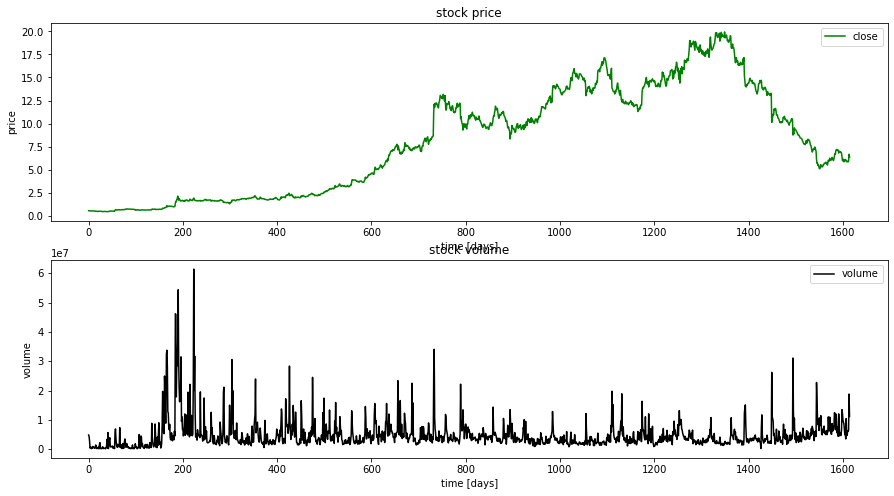

In [10]:
plt.figure(figsize=(15, 8));
plt.subplot(2,1,1);
symbol='A2M'
# plt.plot(df[df.symbol == symbol].Open.values, color='red', label='open')
plt.plot(df[df.symbol == symbol].Close.values, color='green', label='close')
# plt.plot(df[df.symbol == symbol].Low.values, color='blue', label='low')
# plt.plot(df[df.symbol == symbol].High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df[df.symbol == symbol].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

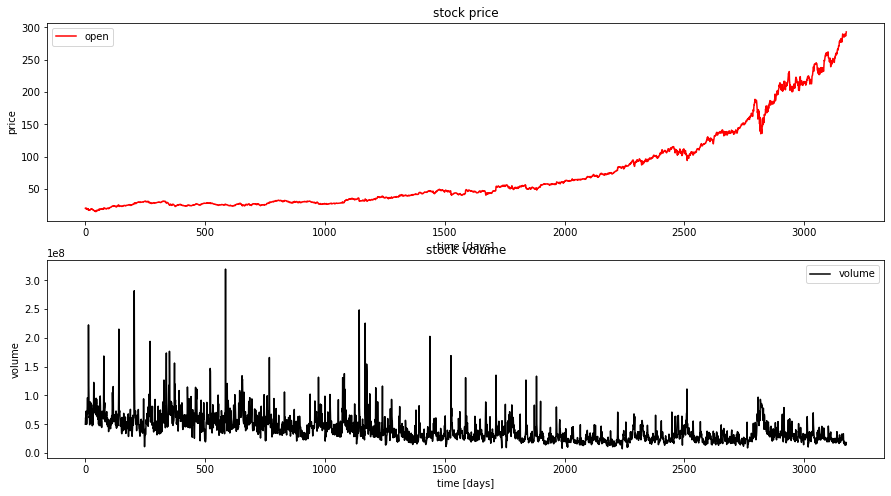

In [13]:
plt.figure(figsize=(15, 8));
plt.subplot(2,1,1);
symbol='MSFT'
plt.plot(df[(df.symbol == symbol)].Close.values, color='red', label='open')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df[df.symbol == symbol].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558735 entries, 0 to 2953
Data columns (total 78 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Date                                      558735 non-null  datetime64[ns]
 1   Open                                      558735 non-null  float64       
 2   High                                      558735 non-null  float64       
 3   Low                                       558735 non-null  float64       
 4   Close                                     558735 non-null  float64       
 5   Adj Close                                 558735 non-null  float64       
 6   Volume                                    558735 non-null  float64       
 7   symbol                                    558735 non-null  object        
 8   pct_change_next1                          558548 non-null  float64       
 9   pct_change_next2 

In [21]:
df.shape

(558735, 161)

In [12]:
df.isna().sum()

Date                          0
Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
symbol                        0
label_next1                   0
label_next2                   0
label_next3                   0
adjClose_next10_max        1550
label_next10_max              0
adjClose_next3to10_max     1395
label_next3to10_max           0
pct_change_price_lag1       155
pct_change_price_lag2       310
pct_change_price_lag3       465
pct_change_price_lag4       620
pct_change_price_lag5       775
pct_change_price_lag6       930
pct_change_price_lag7      1085
pct_change_price_lag8      1240
pct_change_price_lag9      1395
pct_change_price_lag10     1550
pct_change_price_lag11     1705
pct_change_price_lag12     1860
pct_change_price_lag13     2015
pct_change_price_lag14     2170
pct_change_price_lag15     2325
pct_change_price_lag20     3100
pct_chan

In [25]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next3,label_t3,country,industry,sector,exchange,market,pct_change_lag1,pct_change_lag2,pct_change_lag3,pct_change_lag4,pct_change_lag5,pct_change_lag6,pct_change_lag7,pct_change_lag8,pct_change_lag9,pct_change_lag10,pct_change_lag11,pct_change_lag12,pct_change_lag13,pct_change_lag14,pct_change_lag15,pct_change_lag16,pct_change_lag17,pct_change_lag18,pct_change_lag19,pct_change_lag20,pct_change_lag21,pct_change_lag22,pct_change_lag23,pct_change_lag24,pct_change_lag25,pct_change_lag26,pct_change_lag27,pct_change_lag28,pct_change_lag29,pct_change_lag30,ext_features_close_pct_change_01,ext_features_close_pct_change_12,ext_features_close_pct_change_23,ext_features_close_pct_change_34,ext_features_close_pct_change_45,ext_features_high_open_00,ext_features_high_open_01,ext_features_high_open_02,ext_features_high_open_03,ext_features_high_open_04,ext_features_high_open_05,ext_features_high_open_11,ext_features_high_open_22,ext_features_high_open_33,ext_features_high_open_44,ext_features_high_open_55,ext_features_low_open_00,ext_features_low_open_11,ext_features_low_open_22,ext_features_low_open_33,ext_features_low_open_44,ext_features_low_open_55,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup
1007,2009-01-02,11.158798,11.659514,11.094421,11.616595,10.629845,4236220,A,0.033867,0.122537,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236220.0,3.592735e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,2009-01-05,11.530758,12.224607,11.444921,12.010014,10.989847,7171321,A,0.079810,0.092912,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.033867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033306,NaN,NaN,NaN,NaN,0.058433,0.091223,NaN,NaN,NaN,NaN,0.043894,NaN,NaN,NaN,NaN,-0.007472,-0.005786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11407541.0,6.816531e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,2009-01-06,12.231760,13.383405,12.081545,12.968526,11.866942,11834210,A,0.005516,0.021511,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.079810,0.116380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076785,0.033306,NaN,NaN,NaN,0.089980,0.148997,0.181787,NaN,NaN,NaN,0.058433,0.043894,NaN,NaN,NaN,-0.012357,-0.007472,-0.005786,NaN,NaN,NaN,11.162211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23241751.0,1.110805e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,2009-01-07,12.768240,13.204578,12.653791,13.040057,11.932395,9974171,A,0.006582,0.015908,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.005516,0.085765,0.122537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005501,0.076785,0.033306,NaN,NaN,0.033603,0.076528,0.135546,0.168335,NaN,NaN,0.089980,0.058433,0.043894,NaN,NaN,-0.009004,-0.012357,-0.007472,-0.005786,NaN,NaN,11.596395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33215922.0,1.512362e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,2009-01-08,12.989986,13.218884,12.732475,13.125894,12.010939,6242909,A,0.009264,0.038692,1,United States,Diagnostics & Research,Healthcare,NYQ,us_market,0.006582,0.012134,0.092912,0.129926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
df.shape

(573256, 64)

In [41]:
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next2,pct_change_next3,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag16,pct_change_price_lag17,pct_change_price_lag18,pct_change_price_lag19,pct_change_price_lag20,pct_change_price_lag21,pct_change_price_lag22,pct_change_price_lag23,pct_change_price_lag24,pct_change_price_lag25,pct_change_price_lag26,pct_change_price_lag27,pct_change_price_lag28,pct_change_price_lag29,pct_change_price_lag30,pct_change_price_OpenClose,pct_change_price_OpenClose_upOrDownInDay,pct_change_price_OpenClose_countUpCandles_lag5,pct_change_price_OpenClose_countUpCandles_lag10,pct_change_price_OpenClose_countUpCandles_lag20,pct_change_price_OpenClose_CE,pct_change_price_OpenClose_FL,pct_change_price_rangeInDay,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_RSI_lag1,ta_RSI_lag2,ta_RSI_lag3,ta_RSI_lag4,ta_RSI_lag5,ta_RSI_lag6,ta_RSI_lag7,ta_RSI_lag8,ta_RSI_lag9,ta_RSI_lag10,ta_STOCH_slowk,ta_STOCH_slowd,ta_STOCH_slowk_lag1,ta_STOCH_slowd_lag1,ta_STOCH_slowk_lag2,ta_STOCH_slowd_lag2,ta_STOCH_slowk_lag3,ta_STOCH_slowd_lag3,ta_STOCH_slowk_lag4,ta_STOCH_slowd_lag4,ta_STOCH_slowk_lag5,ta_STOCH_slowd_lag5,ta_STOCH_slowk_lag6,ta_STOCH_slowd_lag6,ta_STOCH_slowk_lag7,ta_STOCH_slowd_lag7,ta_STOCH_slowk_lag8,ta_STOCH_slowd_lag8,ta_STOCH_slowk_lag9,ta_STOCH_slowd_lag9,ta_STOCH_slowk_lag10,ta_STOCH_slowd_lag10,ta_MFI,ta_MFI_lag1,ta_MFI_lag2,ta_MFI_lag3,ta_MFI_lag4,ta_MFI_lag5,ta_MFI_lag6,ta_MFI_lag7,ta_MFI_lag8,ta_MFI_lag9,ta_MFI_lag10,ta_OBV,ta_OBV_lag1,ta_OBV_lag2,ta_OBV_lag3,ta_OBV_lag4,ta_OBV_lag5,ta_OBV_lag6,ta_OBV_lag7,ta_OBV_lag8,ta_OBV_lag9,ta_OBV_lag10,ta_AD,ta_AD_lag1,ta_AD_lag2,ta_AD_lag3,ta_AD_lag4,ta_AD_lag5,ta_AD_lag6,ta_AD_lag7,ta_AD_lag8,ta_AD_lag9,ta_AD_lag10,ta_MINUS_DI,ta_PLUS_DI,ta_MINUS_DI_lag1,ta_PLUS_DI_lag1,ta_MINUS_DI_lag2,ta_PLUS_DI_lag2,ta_MINUS_DI_lag3,ta_PLUS_DI_lag3,ta_MINUS_DI_lag4,ta_PLUS_DI_lag4,ta_MINUS_DI_lag5,ta_PLUS_DI_lag5,ta_MINUS_DI_lag6,ta_PLUS_DI_lag6,ta_MINUS_DI_lag7,ta_PLUS_DI_lag7,ta_MINUS_DI_lag8,ta_PLUS_DI_lag8,ta_MINUS_DI_lag9,ta_PLUS_DI_lag9,ta_MINUS_DI_lag10,ta_PLUS_DI_lag10
0,2015-03-31,0.555,0.595,0.53,0.565,0.565,4816294.0,A2M,0.0,-0.017699,-0.035398,0,0,0,0.565,0,0.545,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018018,1,NaN,NaN,NaN,0,0,0.122642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4816294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370484.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['year'] = df['Date'].dt.year

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,sector,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year
0,2015-03-31,0.555,0.595,0.530,0.565,0.565,4816294.0,A2M,Consumer Defensive,0,0,0,0.565,0,0.545,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018018,1,0.072072,-0.045045,0.053097,-0.061947,0.122642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4816294.0,370484.153846,NaN,NaN,NaN,3,1,2015
1,2015-04-01,0.575,0.580,0.555,0.565,0.565,4376660.0,A2M,Consumer Defensive,0,0,0,0.555,0,0.540,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017391,0,0.008696,-0.034783,0.026549,-0.017699,0.045045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4816294.0,-504847.846154,NaN,NaN,NaN,4,2,2015
2,2015-04-02,0.560,0.565,0.535,0.555,0.555,2779640.0,A2M,Consumer Defensive,0,0,0,0.545,0,0.540,0,-0.017699,-0.017699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008929,0,0.008929,-0.044643,0.018018,-0.036036,0.056075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2036654.0,421698.820513,NaN,NaN,NaN,4,2,2015
3,2015-04-07,0.545,0.550,0.540,0.545,0.545,392179.0,A2M,Consumer Defensive,0,0,0,0.540,0,0.540,0,-0.018018,-0.035398,-0.035398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.009174,-0.009174,0.009174,-0.009174,0.018519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1644475.0,421698.820513,NaN,NaN,NaN,4,2,2015
4,2015-04-08,0.545,0.545,0.530,0.540,0.540,668446.0,A2M,Consumer Defensive,0,0,0,0.540,0,0.540,0,-0.009174,-0.027027,-0.044248,-0.044248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009174,0,0.000000,-0.027523,0.009259,-0.018519,0.028302,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,976029.0,644514.153846,NaN,NaN,NaN,4,2,2015


In [15]:
df['Date'].min()

Timestamp('2008-03-12 00:00:00')

In [12]:
df['Date'].max()

Timestamp('2021-08-17 00:00:00')

In [11]:
df = df[df['Date'] >= '2010-01-01']
df.dropna(inplace=True)
df.isna().sum()

Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Adj Close                  0
Volume                     0
symbol                     0
sector                     0
label_next1                0
label_next2                0
label_next3                0
adjClose_next10_max        0
label_next10_max           0
adjClose_next3to10_max     0
label_next3to10_max        0
pct_change_price_lag1      0
pct_change_price_lag2      0
pct_change_price_lag3      0
pct_change_price_lag4      0
pct_change_price_lag5      0
pct_change_price_lag6      0
pct_change_price_lag7      0
pct_change_price_lag8      0
pct_change_price_lag9      0
pct_change_price_lag10     0
pct_change_price_lag11     0
pct_change_price_lag12     0
pct_change_price_lag13     0
pct_change_price_lag14     0
pct_change_price_lag15     0
pct_change_price_lag20     0
pct_change_price_lag30     0
pct_change_price_lag40     0
ext_feat_OpenC

In [14]:
df.isna().sum().sum()

0

In [15]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,year
count,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,4.651240e+05,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,465124.000000,4.651240e+05,4.651240e+05,4.651240e+05,4.651240e+05,4.651240e+05,465124.000000,465124.000000,465124.000000
mean,13.212179,13.359359,13.062580,13.210750,11.186031,3.247621e+06,0.261829,0.329452,0.366707,11.569686,0.719890,11.491366,0.652643,0.000766,0.001504,0.002236,0.002964,0.003687,0.004410,0.005127,0.005845,0.006567,0.007288,0.008005,0.008733,0.009463,0.010194,0.010924,0.014567,0.022009,0.029584,0.000075,0.452847,0.013101,-0.013055,0.013235,-0.012932,0.026735,2.263732,4.526840,9.052478,13.579080,11.180824,11.175678,11.162903,11.137514,11.061242,10.939700,11.180851,11.175716,11.162955,11.137554,11.063143,11.481642,11.176670,10.871699,0.035468,0.035389,0.000079,52.114975,5.114582e+01,5.114115e+01,5.192247e+01,4.950813e+07,-5.414164e+07,6.544031,2.514878,2014.874397
std,21.817650,22.031927,21.595722,21.812265,20.293687,6.123073e+06,0.439631,0.470015,0.481906,20.938792,0.449053,20.816552,0.476131,0.025830,0.035850,0.043559,0.050051,0.055827,0.061017,0.065692,0.070010,0.074118,0.078091,0.081860,0.085565,0.089096,0.092777,0.096238,0.111429,0.139355,0.164875,0.020724,0.497772,0.016724,0.015477,0.016322,0.014632,0.022669,1.157125,1.712761,2.608411,3.389335,20.279232,20.265586,20.231834,20.165587,19.966945,19.657642,20.278503,20.264186,20.228985,20.159638,19.959227,20.771522,20.270206,19.778826,0.450275,0.423666,0.136051,11.815159,2.492805e+01,2.298253e+01,1.718580e+01,2.465756e+08,5.847577e+08,3.394507,1.108096,3.781307
min,0.008000,0.008000,0.007887,0.007887,0.006418,1.000000e+00,0.000000,0.000000,0.000000,0.009627,0.000000,0.008985,0.000000,-0.473779,-0.589746,-0.597561,-0.625005,-0.692309,-0.720281,-0.727276,-0.771429,-0.824177,-0.794873,-0.824177,-0.824177,-0.846155,-0.824177,-0.815385,-0.824572,-0.833346,-0.871804,-0.441176,0.000000,-0.020270,-0.590912,0.000000,-0.550002,0.000000,0.000000,0.000000,0.000000,0.000000,0.007274,0.007702,0.008344,0.009916,0.012460,0.014300,0.007327,0.007775,0.009039,0.011426,0.013863,0.009257,0.007206,-0.021277,-16.221867,-13.734542,-4.935377,3.970391,-2.990201e-13,-1.452665e-13,-1.583990e-13,-2.772178e+09,-7.555543e+09,1.000000,1.0000

In [12]:
list_col_price = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
list_col_price_ta = [col for col in df.columns if 'ta_SMA' in col or 'ta_EMA' in col or 'ta_BBANDS' in col]

scaler = MinMaxScaler()
scaler.fit(df[list_col_price + list_col_price_ta])
df[list_col_price + list_col_price_ta] = scaler.transform(df[list_col_price + list_col_price_ta])

In [13]:
list_prefix = ['ta_MACD_macd', 'ta_OBV', 'ta_AD', 'ta_CCI']

for prefix in list_prefix:
    list_col_scale = [col for col in df.columns if prefix in col]
    
    if len(list_col_scale) == 0:
        continue
        
    scaler = StandardScaler()
    scaler.fit(df[list_col_scale])
    df[list_col_scale] = scaler.transform(df[list_col_scale])
    print(f'done {list_col_scale}')

done ['ta_OBV']
done ['ta_AD', 'ta_ADX']


In [14]:
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,sector,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year
49,2015-06-11,0.001553,0.001538,0.001534,0.001531,0.001554,0.00229,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,0.009524,0.019231,0.019231,0.009524,0.049505,0.12766,0.115789,0.139785,0.12766,0.115789,0.104167,0.12766,0.12766,0.115789,0.104167,0.139785,0.115789,-0.018519,-0.009346,0,0.0,-0.018692,0.009434,-0.009434,0.019048,1.0,3.0,4.0,7.0,0.001489,0.001606,0.001527,0.001611,0.001501,0.001539,0.001644,63.417862,79.18552,81.265292,58.570372,-0.259849,0.088449,1.375823,0.016215,11.578947,6,2,2015


In [15]:
train_cols = ['Open', 'High', 'Low', 'Close', 
              'Adj Close', 'Volume',
              'month', 'quarter'
             ]

category_cols = ['symbol',]
# category_cols = ['sector', 'country', 'exchange']

ta_cols = [col for col in df.columns if 'ta_' in col]
ext_feature_cols = [col for col in df.columns if 'ext_feat_' in col]
pct_change_lag_cols = [col for col in df.columns if 'pct_change_price_lag' in col]

label = 'label_next10_max'

In [16]:
for col in category_cols:
    le = preprocessing.LabelEncoder()
    df['encode_' + col] = le.fit_transform(df[col])
    train_cols.append('encode_' + col)
    print(f'processed column {col}')

processed column symbol


In [17]:
df.dropna(inplace=True)
df.isna().sum().sum()

0

In [60]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next2,pct_change_next3,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag16,pct_change_price_lag17,pct_change_price_lag18,pct_change_price_lag19,pct_change_price_lag20,pct_change_price_lag21,pct_change_price_lag22,pct_change_price_lag23,pct_change_price_lag24,pct_change_price_lag25,pct_change_price_lag26,pct_change_price_lag27,pct_change_price_lag28,pct_change_price_lag29,pct_change_price_lag30,pct_change_price_OpenClose,pct_change_price_OpenClose_upOrDownInDay,pct_change_price_OpenClose_countUpCandles_lag5,pct_change_price_OpenClose_countUpCandles_lag10,pct_change_price_OpenClose_countUpCandles_lag20,pct_change_price_OpenClose_CE,pct_change_price_OpenClose_FL,pct_change_price_rangeInDay,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_RSI_lag1,ta_RSI_lag2,ta_RSI_lag3,ta_RSI_lag4,ta_RSI_lag5,ta_RSI_lag6,ta_RSI_lag7,ta_RSI_lag8,ta_RSI_lag9,ta_RSI_lag10,ta_STOCH_slowk,ta_STOCH_slowd,ta_STOCH_slowk_lag1,ta_STOCH_slowd_lag1,ta_STOCH_slowk_lag2,ta_STOCH_slowd_lag2,ta_STOCH_slowk_lag3,ta_STOCH_slowd_lag3,ta_STOCH_slowk_lag4,ta_STOCH_slowd_lag4,ta_STOCH_slowk_lag5,ta_STOCH_slowd_lag5,ta_STOCH_slowk_lag6,ta_STOCH_slowd_lag6,ta_STOCH_slowk_lag7,ta_STOCH_slowd_lag7,ta_STOCH_slowk_lag8,ta_STOCH_slowd_lag8,ta_STOCH_slowk_lag9,ta_STOCH_slowd_lag9,ta_STOCH_slowk_lag10,ta_STOCH_slowd_lag10,ta_MFI,ta_MFI_lag1,ta_MFI_lag2,ta_MFI_lag3,ta_MFI_lag4,ta_MFI_lag5,ta_MFI_lag6,ta_MFI_lag7,ta_MFI_lag8,ta_MFI_lag9,ta_MFI_lag10,ta_OBV,ta_OBV_lag1,ta_OBV_lag2,ta_OBV_lag3,ta_OBV_lag4,ta_OBV_lag5,ta_OBV_lag6,ta_OBV_lag7,ta_OBV_lag8,ta_OBV_lag9,ta_OBV_lag10,ta_AD,ta_AD_lag1,ta_AD_lag2,ta_AD_lag3,ta_AD_lag4,ta_AD_lag5,ta_AD_lag6,ta_AD_lag7,ta_AD_lag8,ta_AD_lag9,ta_AD_lag10,ta_MINUS_DI,ta_PLUS_DI,ta_MINUS_DI_lag1,ta_PLUS_DI_lag1,ta_MINUS_DI_lag2,ta_PLUS_DI_lag2,ta_MINUS_DI_lag3,ta_PLUS_DI_lag3,ta_MINUS_DI_lag4,ta_PLUS_DI_lag4,ta_MINUS_DI_lag5,ta_PLUS_DI_lag5,ta_MINUS_DI_lag6,ta_PLUS_DI_lag6,ta_MINUS_DI_lag7,ta_PLUS_DI_lag7,ta_MINUS_DI_lag8,ta_PLUS_DI_lag8,ta_MINUS_DI_lag9,ta_PLUS_DI_lag9,ta_MINUS_DI_lag10,ta_PLUS_DI_lag10,month,quarter,encode_symbol
99,2015-08-20,0.001921,0.001902,0.001757,0.001853,0.001882,-0.200328,A2M,0.062500,-0.015625,-0.007812,1,0,0,0.68,1,0.67,1,-0.065693,-0.098592,-0.085714,-0.098592,-0.111111,-0.111111,-0.111111,-0.098592,-0.129252,-0.129252,-0.123288,-0.117241,-0.123288,-0.129252,-0.140940,-0.152318,-0.152318,-0.163399,-0.123288,-0.111111,-0.098592,-0.117241,-0.037594,-0.037594,-0.051852,-0.065693,-0.037594,-0.044776,-0.058824,-0.030303,-0.030303,0,1.0,2.0,6.0,0,0,0.100000,0.002007,0.002054,0.002122,0.002224,0.002146,0.001889,0.001985,0.002033,0.002103,0.002166,0.002146,0.002137,0.002065,0.002117,-0.082392,-0.058742,-0.089991,33.615544,43.976074,52.289935,48.686710,52.358556,56.301389,56.301389,56.301389,53.497622,62.860452,62.860452,19.444444,13.624339,8.333333,12.433862,13.095238,18.650794,15.873016,25.396825,26.984127,27.513228,33.333333,29.166667,22.222222,30.555556,31.944444,40.092593,37.500000,42.777778,50.833333,42.095960,40.000000,33.535354,33.005595,38.597975,40.151044,31.866814,27.269916,45.551033,49.974141,37.307800,52.989289,66.436351,56.231140,-0.290730,-0.282926,-0.279846,-0.280611,-0.279679,-0.278142,-0.278028,-0.277913,-0.278887,-0.277194,-0.277079,0.098652,0.097587,0.098754,0.098371,0.098672,0.099217,0.099501,0.100282,0.100034,0.100644,0.100616,43.331777,18.114550,26.200588,

In [18]:
df_list_date = pd.DataFrame(df['Date'].unique(), columns=['Date'])

In [19]:
# def calc_cum_effect(series, num_day=0):
#     result = series
#     if num_day > 0:
#         for i in range(1, num_day + 1):
#             result += 1/i * series.shift(i, fill_value=0)
#     return result

df_stock_news = pd.read_csv('./exported_data/news_sentiment_analysis/au_stock_news_sentiment_analysis.csv')
df_stock_news['Date'] = pd.to_datetime(df_stock_news['Date'])

stock_news_cols = [col for col in df_stock_news.columns if col not in ['symbol', 'Date']]

df_stock_news = df_list_date.merge(df_stock_news, on='Date', how='outer')
df_stock_news = df_stock_news.sort_values(by=['symbol', 'Date'])
df_stock_news.fillna(0, inplace=True)

# for col in stock_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_stock_news[col] = df_stock_news \
#             .groupby('symbol')[col].transform(calc_cum_effect)

df_stock_news.head()

,Date,symbol,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader
12629,2018-09-27,A2M,-1.0,0.0
12697,2018-10-03,A2M,-1.0,1.0
12714,2018-10-04,A2M,-1.0,1.0
12731,2018-10-05,A2M,-1.0,1.0
12749,2018-10-08,A2M,-1.0,1.0


In [20]:
df_political_news = pd.read_csv('./exported_data/news_sentiment_analysis/au_political_news_sentiment_analysis.csv')
df_political_news['Date'] = pd.to_datetime(df_political_news['Date'])
political_news_cols = [col for col in df_political_news.columns if col not in ['symbol', 'Date']]

df_political_news = df_list_date.merge(df_political_news, on='Date', how='outer')
df_political_news = df_political_news.sort_values(by=['Date'])
df_political_news.fillna(0, inplace=True)

# for col in political_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_political_news[col] = df_political_news[col].transform(calc_cum_effect)
        
df_political_news.head()

,Date,political_daily_sentiment_score_vader
2928,2005-01-19,0.0
2929,2005-02-22,0.0
2930,2007-08-19,0.0
2931,2007-11-18,0.0
2932,2007-11-23,0.0


In [17]:
# df_political_news_us = pd.read_csv('./exported_data/news_sentiment_analysis/us_political_news_sentiment_analysis.csv')
# df_political_news_us['Date'] = pd.to_datetime(df_political_news_us['Date'])

# df_political_news_us.columns = [col + '_us' if col not in ['symbol', 'Date'] else col for col in df_political_news_us.columns]

# political_news_cols_us = [col for col in df_political_news_us.columns if col not in ['symbol', 'Date']]

# df_political_news_us = df_list_date.merge(df_political_news_us, on='Date', how='outer')
# df_political_news_us = df_political_news_us.sort_values(by=['Date'])
# df_political_news_us.fillna(0, inplace=True)

# # for col in political_news_cols:
# #     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
# #         df_political_news[col] = df_political_news[col].transform(calc_cum_effect)
        
# df_political_news_us.head()

,Date,political_news_in_day_us,political_news_vader_neg_us,political_news_vader_pos_us,political_news_vader_neu_us,political_news_vader_compound_us
2928,2005-01-02,1.0,0.494,0.000,0.506,-0.5994
2929,2005-01-03,1.0,0.000,0.000,1.000,0.0000
2930,2005-01-05,1.0,0.630,0.000,0.370,-0.6249
2931,2005-01-06,2.0,0.830,0.131,1.039,-1.1951
2932,2005-01-07,1.0,0.615,0.000,0.385,-0.7506


In [21]:
df = df.merge(df_stock_news, on=['symbol', 'Date'], how='left')
df = df.merge(df_political_news, on=['Date'], how='left')
# df = df.merge(df_political_news_us, on=['Date'], how='left')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,sector,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader,political_daily_sentiment_score_vader
0,2015-06-11,0.001553,0.001538,0.001534,0.001531,0.001554,0.002290,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,0.009524,0.019231,0.019231,0.009524,0.049505,0.127660,0.115789,0.139785,0.127660,0.115789,0.104167,0.127660,0.127660,0.115789,0.104167,0.139785,0.115789,-0.018519,-0.009346,0,0.000000,-0.018692,0.009434,-0.009434,0.019048,1.0,3.0,4.0,7.0,0.001489,0.001606,0.001527,0.001611,0.001501,0.001539,0.001644,63.417862,79.185520,81.265292,58.570372,-0.259849,0.088449,1.375823,0.016215,11.578947,6,2,2015,0,NaN,NaN,-0.466667
1,2015-06-12,0.001508,0.001538,0.001504,0.001516,0.001539,0.003141,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,-0.009434,0.000000,0.009615,0.009615,0.000000,0.039604,0.117021,0.105263,0.129032,0.117021,0.105263,0.093750,0.117021,0.117021,0.105263,0.105263,0.050000,-0.009434,0.009615,1,0.028846,-0.009615,0.019048,-0.019048,0.038835,1.0,4.0,5.0,7.0,0.001497,0.001604,0.001535,0.001614,0.001516,0.001554,0.001660,60.669992,69.871795,76.636501,55.800331,-0.264126,0.088449,1.229415,0.016486,11.702128,6,2,2015,0,NaN,NaN,-0.500000
2,2015-06-15,0.001538,0.001552,0.001534,0.001516,0.001539,0.002625,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,0.000000,-0.009434,0.000000,0.009615,0.009615,0.000000,0.039604,0.117021,0.105263,0.129032,0.117021,0.105263,0.093750,0.117021,0.117021,0.129032,0.050000,-0.027778,-0.009434,0,0.018868,-0.009434,0.028571,0.000000,0.028571,1.0,4.0,5.0,7.0,0.001506,0.001601,0.001541,0.001616,0.001521,0.001564,0.001673,60.669992,55.000000,68.019105,57.496248,-0.264126,0.086956,1.125513,0.016379,12.903226,6,2,2015,0,NaN,NaN,-1.000000
3,2015-06-16,0.001523,0.001523,0.001519,0.001502,0.001524,0.000853,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,-0.009524,-0.009524,-0.018868,-0.009524,0.000000,0.000000,-0.009524,0.029703,0.106383,0.094737,0.118280,0.106383,0.094737,0.083333,0.106383,0.106383,0.019608,0.000000,-0.009524,0,0.009524,-0.009524,0.019231,0.000000,0.019231,1.0,3.0,5.0,6.0,0.001514,0.001599,0.001546,0.001618,0.001524,0.001566,0.001676,57.767077,36.666667,53.846154,55.154201,-0.265288,0.086471,0.981193,0.015924,9.473684,6,2,2015,0,NaN,NaN,-0.454545
4,2015-06-17,0.001523,0.001508,0.001519,0.001502,0.001524,0.002260,A2M,Consumer Defensive,0,0,1,0.685,1,0.685,1,0.000000,-0.009524,-0.009524,-0.018868,-0.009524,0.000000,0.000000,-0.009524,0.029703,0.106383,0.094737,0.118280,0.106383,0.094737,0.083333,0.061224,0.029703,0.000000,-0.009524,0,0.000000,-0.009524,0.009615,0.000000,0.009615,1.0,3.0,4.0,6.0,0.001519,0.001597,0.001550,0.001619,0.001526,0.001565,0.001670,57.767077,26.666667,39.444444,61.070906,-0.265288,0.085186,0.847182,0.015144,10.638298,6,2,2015,0,NaN,NaN,-0.066667


In [22]:
df[stock_news_cols] = df[stock_news_cols].fillna(0)
df[political_news_cols] = df[political_news_cols].fillna(0)
# df[political_news_cols_us] = df[political_news_cols_us].fillna(0)

In [20]:
# for col in df.columns:
#     if 'obj' in col:
#         if col in stock_news_cols:
#             stock_news_cols.remove(col)
#         if col in political_news_cols:
#             political_news_cols.remove(col)
#         if col in political_news_cols_us:
#             political_news_cols_us.remove(col)
# #         if col in stock_market_news_cols:
# #             stock_market_news_cols.remove(col) 

In [23]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader,political_daily_sentiment_score_vader
count,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,4.191180e+05,4.191180e+05,4.191180e+05,4.191180e+05,4.191180e+05,4.191180e+05,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000,419118.000000
mean,0.039926,0.039959,0.039778,0.039740,0.034815,0.009305,0.253456,0.323408,0.361974,12.091312,0.716154,12.013401,0.649984,0.000770,0.001519,0.002266,0.003019,0.003767,0.004521,0.005273,0.006027,0.006786,0.007540,0.008290,0.009051,0.009810,0.010568,0.011325,0.015043,0.022585,0.030267,0.000143,0.455884,0.012355,-0.012248,0.012379,-0.012222,0.025086,2.279186,4.558826,9.117284,13.675709,0.036391,0.037576,0.036450,0.037797,0.034717,0.035196,0.035134,52.294710,5.134631e+01,5.135145e+01,5.205657e+01,-5.599058e-16,-2.036105e-15,9.393901e-16,0.321004,0.754030,6.434847,2.480139,2015.578283,75.997910,-0.034739,0.023378,-0.167178
std,0.066314,0.066300,0.066124,0.065993,0.062750,0.016646,0.434990,0.467777,0.480572,21.742543,0.450864,21.618747,0.476975,0.023807,0.032967,0.040141,0.046197,0.051588,0.056546,0.061012,0.065144,0.069049,0.072751,0.076236,0.079675,0.082924,0.086323,0.089515,0.103253,0.128896,0.151628,0.018863,0.498051,0.015128,0.013868,0.014404,0.013352,0.019944,1.154022,1.703596,2.584037,3.344931,0.065495,0.067446,0.065587,0.067820,0.062449,0.063425,0.063290,11.818731,2.483161e+01,2.289668e+01,1.705625e+01,1.000001e+00,1.000001e+00,1.000001e+00,0.547964,7.275086,3.401786,1.110451,3.307249,44.435658,0.183654,0.202673,0.404939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,0.000000,0.010000,0.000000,-0.473779,-0.589746,-0.597561,-0.607143,-0.692309,-0.720281,-0.720281,-0.771429,-0.824177,-0.794873,-0.824177,-0.824177,-0.846155,-0.824177,-0.815385,-0.824572,-0.830136,-0.823776,-0.441176,0.000000,-0.020270,-0.590912,0.000000,-0.550002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.970391,-2.990201e-13,-1.314504e-13,-1.583990e-13,-1.103951e+01,-1.220859e+01,-1.872885e+00,0.000861,-79.487296,1.000000,1.000000,2010.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.009375,0.009399,0.009323,0.009328,0.007563,0.001437,0.000000,0.000000,0.000000,2.637369,0.000000,2.618376,

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total
0,2015-08-20,0.001921,0.001902,0.001757,0.001854,0.001886,0.001869,A2M,1,0,0,0.68,1,0.67,1,-0.065693,-0.098592,-0.085714,-0.098592,-0.111111,-0.111111,-0.111111,-0.098592,-0.129252,-0.129252,-0.123288,-0.117241,-0.123288,-0.129252,-0.140940,-0.111111,-0.030303,0.007874,-0.030303,0,0.000000,-0.090909,0.031250,-0.062500,0.100000,1.0,2.0,6.0,13.0,0.002011,0.002059,0.002129,0.002230,0.002146,0.001889,0.001989,0.002038,0.002108,0.002169,0.002146,0.002137,0.002071,0.002044,-0.074995,-0.050217,-0.091829,33.615544,19.444444,13.624339,33.005595,-0.238963,0.096405,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,10.0,1.679,1.165,7.156,-0.7829,2.625,3.125,61.250,-0.500
1,2015-08-21,0.001862,0.001990,0.001816,0.001971,0.002005,0.000972,A2M,0,0,0,0.67,0,0.67,0,0.062500,-0.007299,-0.042254,-0.028571,-0.042254,-0.055556,-0.055556,-0.055556,-0.042254,-0.074830,-0.074830,-0.068493,-0.062069,-0.068493,-0.074830,-0.068493,0.000000,0.046154,0.062500,1,0.078125,-0.031250,0.014706,-0.088235,0.112903,2.0,3.0,7.0,13.0,0.001981,0.002041,0.002113,0.002222,0.002156,0.001893,0.002007,0.002036,0.002098,0.002162,0.002147,0.002095,0.002041,0.002026,-0.078961,-0.056920,-0.084080,45.831891,34.299517,20.692432,43.877391,-0.235049,0.097584,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9.0,0.620,0.315,8.065,-0.6323,3.375,2.625,54.000,0.750
2,2015-08-24,0.001877,0.001902,0.001831,0.001824,0.001857,0.000603,A2M,0,1,1,0.67,1,0.67,1,-0.073529,-0.015625,-0.080292,-0.112676,-0.100000,-0.112676,-0.125000,-0.125000,-0.125000,-0.112676,-0.142857,-0.142857,-0.136986,-0.131034,-0.136986,-0.176471,-0.059701,-0.023256,-0.023256,0,0.023256,-0.031008,0.047619,-0.007937,0.056000,2.0,3.0,6.0,12.0,0.001927,0.001998,0.002088,0.002201,0.002163,0.001895,0.001940,0.001985,0.002062,0.002140,0.002142,0.002092,0.002003,0.001952,-0.090924,-0.064826,-0.099055,36.732369,43.390426,32.378129,42.129250,-0.237476,0.096853,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,13.0,1.787,1.717,9.496,-0.6172,4.375,2.875,69.750,1.500
3,2015-08-25,0.001803,0.001844,0.001757,0.001839,0.001871,0.000835,A2M,1,1,1,0.67,1,0.66,1,0.007937,-0.066176,-0.007812,-0.072993,-0.105634,-0.092857,-0.105634,-0.118056,-0.118056,-0.118056,-0.105634,-0.136054,-0.136054,-0.130137,-0.124138,-0.158940,-0.045113,-0.007812,0.024194,1,0.032258,-0.032258,0.007874,-0.055118,0.066667,2.0,3.0,7.0,13.0,0.001922,0.001953,0.002062,0.002183,0.002170,0.001898,0.001914,0.001956,0.002036,0.002123,0.002138,0.002019,0.001965,0.001951,-0.099273,-0.072925,

In [95]:
# del data_train_valid, data_test
# del data_train, data_valid
# del X_train_val, y_train_val
del X_train, X_valid, y_train, y_valid
del X_test, y_test
del dtrain, dvalid
gc.collect()

230

In [28]:
df.shape

(1337261, 126)

In [37]:
df['Date'].min()

Timestamp('2008-05-26 00:00:00')

In [38]:
df['Date'].max()

Timestamp('2021-08-03 00:00:00')

In [23]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01' #'2021-01-01'
test_date_start = '2021-05-01' #'2021-05-01'
test_date_end = '2021-07-31'

data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start)]
data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)]

# data_train_valid = df[(df["Date"] >= train_date_start) & (df["Date"] < test_date_start)]
data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

data_train = shuffle(data_train).reset_index(drop=True)
# data_train_valid = shuffle(data_train_valid).reset_index(drop=True)

In [29]:
# X_train = data_train[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

# X_train = data_train[training_cols]
X_train = data_train[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_train = data_train[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_train = data_train[[label]]

In [30]:
# X_valid = data_valid[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

X_valid = data_valid[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_valid = data_valid[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_valid = data_valid[[label]]

In [31]:
# X_test = data_test[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                    stock_news_cols + stock_market_news_cols + 
#                    political_news_cols + indicator_news_cols]

X_test = data_test[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_test = data_test[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_test = data_test[[label]]

In [174]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression" "binary"
#     "num_class" : 3,
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_leaves": 50,
#     "max_bin": 32,
#     "feature_fraction": 0.9,
#     "bagging_fraction" : 0.7,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss", # "binary_logloss"
    # "metric" : "rmse"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=1000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=10,
                  early_stopping_rounds=100)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 123252, number of negative: 222036
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16356
[LightGBM] [Info] Number of data points in the train set: 345288, number of used features: 77
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356954 -> initscore=-0.588608
[LightGBM] [Info] Start training from score -0.588608
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.650591	valid_1's binary_logloss: 0.66972
[20]	training's binary_logloss: 0.649664	valid_1's binary_logloss: 0.669009
[30]	training's binary_logloss: 0.648835	valid_1's binary_logloss: 0.668453
[40]	training's binary_logloss: 0.648093	valid_1's

In [175]:
model.predict(X_valid)

array([0.38178416, 0.37750757, 0.40530039, ..., 0.41558638, 0.40348386,
       0.44982033])

0.3086512225135092
              precision    recall  f1-score   support

           0       0.80      0.62      0.70     48748
           1       0.24      0.44      0.31     13255

    accuracy                           0.58     62003
   macro avg       0.52      0.53      0.51     62003
weighted avg       0.68      0.58      0.62     62003



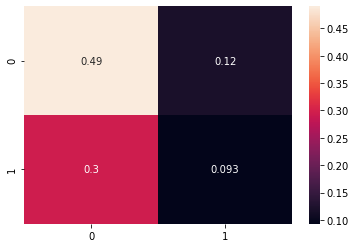

In [176]:
threshold = 0.4
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f1_score(y_valid_pred, y_valid))
print(classification_report(y_valid_pred, y_valid))

cm = confusion_matrix(y_valid, y_valid_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

lightgbm
threshold = 0.4
label = label_next3
f1 score: 0.1795598169535847
accuracy score: 0.6199656808317351
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      6260
           1       0.44      0.11      0.18      3647

    accuracy                           0.62      9907
   macro avg       0.54      0.51      0.47      9907
weighted avg       0.56      0.62      0.54      9907



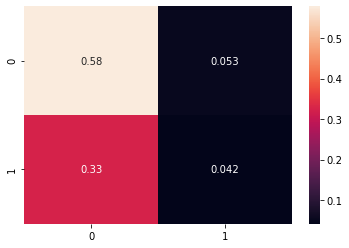

In [177]:
threshold = 0.4
y_pred = (model.predict(X_test) >= threshold).astype('int')

print('lightgbm')
print(f'threshold = {threshold}')
print(f'label = {label}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [33]:
data_test['predict'] = y_pred

data_test[(data_test['Date'] >= '2021-07-01') & (data_test['Date'] < '2021-08-01')][[
    'Date', 'symbol',
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'label_next10_max', 'predict'
]].to_csv('./exported_data/au_prediction_202107_20210907.csv')

<ipython-input-33-c72eeb7ce04d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict'] = y_pred


In [67]:
# train_valid_date_start = '2015-01-01'
# # valid_date_start = '2020-01-01'
# test_date_start = '2021-04-01'
# test_date_end = '2021-07-31'

# data_train_valid = df[(df["Date"] >= train_valid_date_start) & (df["Date"] < test_date_start)]
# data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

In [75]:
list_cols_training = train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

In [79]:
kf = KFold(n_splits=5)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
#     "num_leaves": 50,
#     "max_bin": 32,
    "feature_fraction": 0.55,
    "bagging_fraction" : 0.55,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

models = []

for fold, (train_index, _) in enumerate(kf.split(data_train)):
    X_train = data_train.iloc[train_index][list_cols_training]
    y_train = data_train.iloc[train_index][label]
    
#     X_valid = data_train_valid.iloc[valid_index][list_cols_training]
#     y_valid = data_train_valid.iloc[valid_index][label]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)
    
    print('*' * 50)
    print(f'training with fold {fold}')
    
    model = lgb.train(params=params, 
                      train_set=dtrain, 
                      num_boost_round=5000, 
                      valid_sets=[dtrain, dvalid], 
                      verbose_eval=20,
                      early_stopping_rounds=50)
     
    models.append(model)

**************************************************
training with fold 0
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 382576, number of negative: 672145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29046
[LightGBM] [Info] Number of data points in the train set: 1054721, number of used features: 129
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362727 -> initscore=-0.563547
[LightGBM] [Info] Start training from score -0.563547
Training until validation scores don't improve for 50 rounds
[20]	training's binary_logloss: 0.63542	valid_1's binary_logloss: 0.69144
[40]	training's binary_logloss: 0.622267	valid_1's binary_logloss: 0.693279
[60]	training's binary_logloss: 0.61355	valid_1's bina

In [83]:
preds = []

threshold = 0.45

for model in models:
    pred = model.predict(X_valid)
    preds.append(pred)
    
y_pred = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.98      0.72     22971
           1       0.49      0.03      0.05     17783

    accuracy                           0.56     40754
   macro avg       0.53      0.50      0.38     40754
weighted avg       0.53      0.56      0.43     40754



In [88]:
preds = []
threshold = 0.4

for model in models:
    pred = model.predict(X_test)
    preds.append(pred)
    
y_pred = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.88      0.76     20404
           1       0.43      0.17      0.24     10912

    accuracy                           0.63     31316
   macro avg       0.55      0.52      0.50     31316
weighted avg       0.58      0.63      0.58     31316



In [89]:
tmp = pd.DataFrame(y_pred, columns=['label']).groupby('label').size().reset_index()
tmp['percent'] = tmp[0] / tmp[0].sum()
tmp

,label,0,percent
0,0,27000,0.862179
1,1,4316,0.137821


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

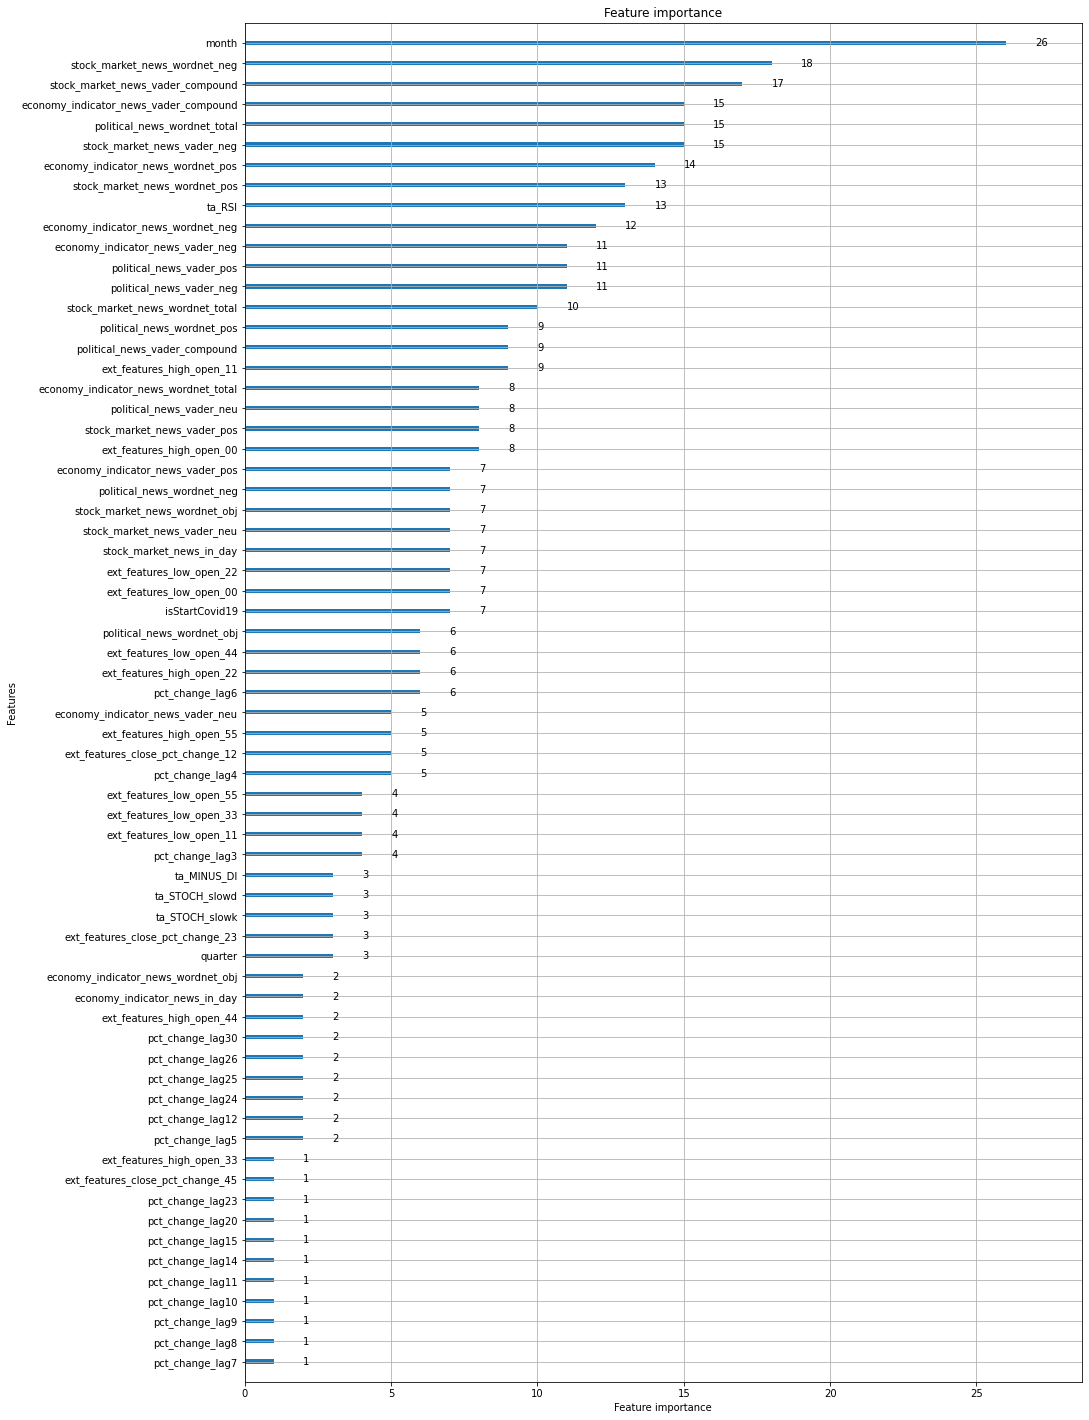

In [66]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

In [74]:
# train_valid_date_start = '2015-01-01'
# # valid_date_start = '2020-01-01'
# test_date_start = '2021-04-01'
# test_date_end = '2021-07-31'

# data_train_valid = df[(df["Date"] >= train_valid_date_start) & (df["Date"] < test_date_start)]
# data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

In [90]:
list_cols_training = train_cols + pct_change_lag_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

label = ['label']

In [78]:
# X_train_val = data_train_valid[list_cols_training]
# y_train_val = data_train_valid[label]

# X_test = data_test[list_cols_training]
# y_test = data_test[label]

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, 
                                                      test_size=0.2, stratify=y_train_val, 
                                                      random_state=1000)

In [63]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total
0,2015-08-20,0.001921,0.001902,0.001757,0.001854,0.001886,0.001869,A2M,1,0,0,0.68,1,0.67,1,-0.065693,-0.098592,-0.085714,-0.098592,-0.111111,-0.111111,-0.111111,-0.098592,-0.129252,-0.129252,-0.123288,-0.117241,-0.123288,-0.129252,-0.140940,-0.111111,-0.030303,0.007874,-0.030303,0,0.000000,-0.090909,0.031250,-0.062500,0.100000,1.0,2.0,6.0,13.0,0.002011,0.002059,0.002129,0.002230,0.002146,0.001889,0.001989,0.002038,0.002108,0.002169,0.002146,0.002137,0.002071,0.002044,-0.074995,-0.050217,-0.091829,33.615544,19.444444,13.624339,33.005595,-0.238963,0.096405,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,10.0,1.679,1.165,7.156,-0.7829,2.625,3.125,61.250,-0.500
1,2015-08-21,0.001862,0.001990,0.001816,0.001971,0.002005,0.000972,A2M,0,0,0,0.67,0,0.67,0,0.062500,-0.007299,-0.042254,-0.028571,-0.042254,-0.055556,-0.055556,-0.055556,-0.042254,-0.074830,-0.074830,-0.068493,-0.062069,-0.068493,-0.074830,-0.068493,0.000000,0.046154,0.062500,1,0.078125,-0.031250,0.014706,-0.088235,0.112903,2.0,3.0,7.0,13.0,0.001981,0.002041,0.002113,0.002222,0.002156,0.001893,0.002007,0.002036,0.002098,0.002162,0.002147,0.002095,0.002041,0.002026,-0.078961,-0.056920,-0.084080,45.831891,34.299517,20.692432,43.877391,-0.235049,0.097584,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9.0,0.620,0.315,8.065,-0.6323,3.375,2.625,54.000,0.750
2,2015-08-24,0.001877,0.001902,0.001831,0.001824,0.001857,0.000603,A2M,0,1,1,0.67,1,0.67,1,-0.073529,-0.015625,-0.080292,-0.112676,-0.100000,-0.112676,-0.125000,-0.125000,-0.125000,-0.112676,-0.142857,-0.142857,-0.136986,-0.131034,-0.136986,-0.176471,-0.059701,-0.023256,-0.023256,0,0.023256,-0.031008,0.047619,-0.007937,0.056000,2.0,3.0,6.0,12.0,0.001927,0.001998,0.002088,0.002201,0.002163,0.001895,0.001940,0.001985,0.002062,0.002140,0.002142,0.002092,0.002003,0.001952,-0.090924,-0.064826,-0.099055,36.732369,43.390426,32.378129,42.129250,-0.237476,0.096853,8,3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,13.0,1.787,1.717,9.496,-0.6172,4.375,2.875,69.750,1.500
3,2015-08-25,0.001803,0.001844,0.001757,0.001839,0.001871,0.000835,A2M,1,1,1,0.67,1,0.66,1,0.007937,-0.066176,-0.007812,-0.072993,-0.105634,-0.092857,-0.105634,-0.118056,-0.118056,-0.118056,-0.105634,-0.136054,-0.136054,-0.130137,-0.124138,-0.158940,-0.045113,-0.007812,0.024194,1,0.032258,-0.032258,0.007874,-0.055118,0.066667,2.0,3.0,7.0,13.0,0.001922,0.001953,0.002062,0.002183,0.002170,0.001898,0.001914,0.001956,0.002036,0.002123,0.002138,0.002019,0.001965,0.001951,-0.099273,-0.072925,

In [39]:
# label = 'label_next3'
label

'label_next10_max'

In [40]:
# params = {'objective':'binary:logistic',
#           'max_depth': 6, # default 6
#           'alpha': 10,
#           'gamma' : 0, # default 0
#           'subsample' : 1, # default 1
#           'colsample_bytree' : 1, # default 1
#           'min_child_weight' : 1, # default 1
#           'learning_rate': 0.1,
#           'alpha' : 0, # default 0
# #           'eval_metric' : 'auc',
#           'n_estimators' : 1000,
#           'verbosity' : 1,
#           'seed' : 10
#          }    

params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

model = XGBClassifier(**params) 
model.fit(X_train, y_train,
          eval_metric="logloss",
          eval_set=[(X_train, y_train), (X_valid, y_valid)], 
          early_stopping_rounds=100,
          verbose=10)

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68758	validation_1-logloss:0.68695
[10]	validation_0-logloss:0.64660	validation_1-logloss:0.64144
[20]	validation_0-logloss:0.62316	validation_1-logloss:0.61543
[30]	validation_0-logloss:0.60956	validation_1-logloss:0.60030
[40]	validation_0-logloss:0.60115	validation_1-logloss:0.59167
[50]	validation_0-logloss:0.59624	validation_1-logloss:0.58605
[60]	validation_0-logloss:0.59292	validation_1-logloss:0.58310
[70]	validation_0-logloss:0.59061	validation_1-logloss:0.58126
[80]	validation_0-logloss:0.58864	validation_1-logloss:0.58062
[90]	validation_0-logloss:0.58705	validation_1-logloss:0.57985
[100]	validation_0-logloss:0.58580	validation_1-logloss:0.57949
[110]	validation_0-logloss:0.58455	validation_1-logloss:0.57941
[120]	validation_0-logloss:0.58317	validation_1-logloss:0.57957
[130]	validation_0-logloss:0.58208	validation_1-logloss:0.57961
[140]	validation_0-logloss:0.58082	validation_1-logloss:0.57966
[150]	validation_0-logloss:0.57977	validation_1-log

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.23, eval_metric='logloss',
              gamma=0.44, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.73, tree_method='exact',
              validate_parameters=1, verbosity=0)

xgboost
threshold = 0.7
label = label_next10_max
f1 score 0.5425728625517302
accuracy score: 0.47562329665892805
              precision    recall  f1-score   support

           0       0.28      0.61      0.39      2692
           1       0.74      0.43      0.54      7215

    accuracy                           0.48      9907
   macro avg       0.51      0.52      0.46      9907
weighted avg       0.62      0.48      0.50      9907



C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


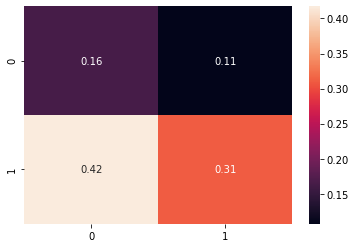

In [44]:
threshold = 0.7

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')

print('xgboost')
print(f'threshold = {threshold}')
print(f'label = {label}')
print(f'f1 score {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# Test The Predictive Value of News Sentiment

In [21]:
train_date_start = datetime.date(2010, 1, 1)

valid_date_end = datetime.date(2016, 6, 30)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

test_date_start = datetime.date(2021, 1, 1)
test_date_end = datetime.date(2021, 7, 31)

count = 0
predictions = []
while True:    
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))].copy()
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))].copy()
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))].copy()    
    
    list_training_cols = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols \
                         + stock_news_cols + political_news_cols + political_news_cols_us
    
    X_train = data_train[list_training_cols]
    y_train = data_train[label]
    
    X_valid = data_valid[list_training_cols]
    y_valid = data_valid[label]
    
    X_test = data_test[list_training_cols]
    y_test = data_test[label]
    
    tmp = data_test.copy()        
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    predictions.append(y_pred_raw)
    
    # move to next period
    valid_date_start = valid_date_end + datetime.timedelta(days=1)
    valid_date_end = (valid_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    #check
    if valid_date_end >= test_date_start:
        break
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-12-31
valid_date_start 2016-01-01
valid_date_end   2016-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68743	validation_1-logloss:0.68800
[20]	validation_0-logloss:0.62157	validation_1-logloss:0.61320
[40]	validation_0-logloss:0.59767	validation_1-logloss:0.58481
[60]	validation_0-logloss:0.58727	validation_1-logloss:0.57435
[80]	validation_0-logloss:0.58064	validation_1-logloss:0.57074
[100]	validation_0-logloss:0.57593	validation_1-logloss:0.56912
[120]	validation_0-logloss:0.57180	validation_1-logloss:0.56857
[140]	validation_0-logloss:0.56855	validation_1-logloss:0.56873
[160]	validation_0-logloss:0.56503	validation_1-logloss:0.56902
[180]	validation_0-logloss:0.56196	validation_1-logloss:0.56904
[200]	validation_0-logloss:0.55909	validation_1-logloss:0.56998
[220]	validation_0-logloss:0.55667	validation_1-logloss:0.57089
[233]	validation_0-logloss:0.55516	validation_1-logloss:0.57126
**************************************************
mode 1
train_date_start 2010-01-01
train_date_end   2016-06-30
valid_date_start 2016-07-01
valid_date_end   2016-12-31
test

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[0]	validation_0-logloss:0.68734	validation_1-logloss:0.68739
[20]	validation_0-logloss:0.62006	validation_1-logloss:0.62305
[40]	validation_0-logloss:0.59563	validation_1-logloss:0.60414
[60]	validation_0-logloss:0.58489	validation_1-logloss:0.59777
[80]	validation_0-logloss:0.57845	validation_1-logloss:0.59610
[100]	validation_0-logloss:0.57362	validation_1-logloss:0.59532
[120]	validation_0-logloss:0.57020	validation_1-logloss:0.59571
[140]	validation_0-logloss:0.56673	validation_1-logloss:0.59622
[160]	validation_0-logloss:0.56379	validation_1-logloss:0.59704
[180]	validation_0-logloss:0.56107	validation_1-logloss:0.59795
[200]	validation_0-logloss:0.55874	validation_1-logloss:0.59906
[202]	validation_0-logloss:0.55843	validation_1-logloss:0.59942
**************************************************
mode 2
train_date_start 2010-01-01
train_date_end   2016-12-31
valid_date_start 2017-01-01
valid_date_end   2017-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31
[0]	validati

[200]	validation_0-logloss:0.57113	validation_1-logloss:0.56392
[220]	validation_0-logloss:0.56945	validation_1-logloss:0.56388
[240]	validation_0-logloss:0.56787	validation_1-logloss:0.56376
[242]	validation_0-logloss:0.56776	validation_1-logloss:0.56376


**************************************************
model for au stocks - with cross validation and us politic news
threshold : 0.65
f1 score: 0.8138119621457869
accuracy score: 0.692807855626327
              precision    recall  f1-score   support

           0       0.27      0.08      0.12      6135
           1       0.73      0.92      0.81     16473

    accuracy                           0.69     22608
   macro avg       0.50      0.50      0.47     22608
weighted avg       0.60      0.69      0.63     22608



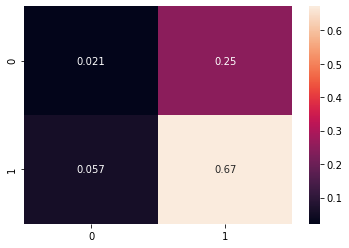

In [24]:
test_prediction = pd.DataFrame(np.array(predictions).T)

threshold = 0.65
y_pred = test_prediction.sum(axis=1) / len(test_prediction.columns)
y_pred = (y_pred >= threshold).astype(int)

print('*' * 50)
print('model for au stocks - with cross validation and us politic news')
print(f'threshold : {threshold}')
# print('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# Train test plit 

# Stock Prediction for Sectors

In [45]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,sector,label_next1,label_next2,label_next3,adjClose_next10_max,label_next10_max,adjClose_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays_5,ext_feat_countUpDays_10,ext_feat_countUpDays_20,ext_feat_countUpDays_30,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,year,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_lm_pos,stock_news_lm_neg,stock_news_lm_polar,stock_news_lm_subject,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound
0,2015-06-11,0.001553,0.001538,0.001534,0.001531,0.001554,0.002290,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,0.009524,0.019231,0.019231,0.009524,0.049505,0.127660,0.115789,0.139785,0.127660,0.115789,0.104167,0.127660,0.127660,0.115789,0.104167,0.139785,0.115789,-0.018519,-0.009346,0,0.000000,-0.018692,0.009434,-0.009434,0.019048,1.0,3.0,4.0,7.0,0.001489,0.001606,0.001527,0.001611,0.001501,0.001539,0.001644,63.417862,79.185520,81.265292,58.570372,-0.259849,0.088449,1.375823,0.016215,11.578947,6,2,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.906,1.544,11.550,-2.5512
1,2015-06-12,0.001508,0.001538,0.001504,0.001516,0.001539,0.003141,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,-0.009434,0.000000,0.009615,0.009615,0.000000,0.039604,0.117021,0.105263,0.129032,0.117021,0.105263,0.093750,0.117021,0.117021,0.105263,0.105263,0.050000,-0.009434,0.009615,1,0.028846,-0.009615,0.019048,-0.019048,0.038835,1.0,4.0,5.0,7.0,0.001497,0.001604,0.001535,0.001614,0.001516,0.001554,0.001660,60.669992,69.871795,76.636501,55.800331,-0.264126,0.088449,1.229415,0.016486,11.702128,6,2,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.157,0.475,11.368,-1.0308
2,2015-06-15,0.001538,0.001552,0.001534,0.001516,0.001539,0.002625,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,0.000000,-0.009434,0.000000,0.009615,0.009615,0.000000,0.039604,0.117021,0.105263,0.129032,0.117021,0.105263,0.093750,0.117021,0.117021,0.129032,0.050000,-0.027778,-0.009434,0,0.018868,-0.009434,0.028571,0.000000,0.028571,1.0,4.0,5.0,7.0,0.001506,0.001601,0.001541,0.001616,0.001521,0.001564,0.001673,60.669992,55.000000,68.019105,57.496248,-0.264126,0.086956,1.125513,0.016379,12.903226,6,2,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,3.395,0.454,13.151,-4.9251
3,2015-06-16,0.001523,0.001523,0.001519,0.001502,0.001524,0.000853,A2M,Consumer Defensive,0,0,0,0.685,1,0.685,1,-0.009524,-0.009524,-0.018868,-0.009524,0.000000,0.000000,-0.009524,0.029703,0.106383,0.094737,0.118280,0.106383,0.094737,0.083333,0.106383,0.106383,0.019608,0.000000,-0.009524,0,0.009524,-0.009524,0.019231,0.000000,0.019231,1.0,3.0,5.0,6.0,0.001514,0.001599,0.001546,0.001618,0.001524,0.001566,0.001676,57.767077,36.666667,53.846154,55.154201,-0.265288,0.086471,0.981193,0.015924,9.473684,6,2,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.523,1.172,15.306,-2.4727
4,2015-06-17,0.001523,0.001508,0.001519,0.001502,0.001524,0.002260,A2M,Consumer Defensive,0,0,1,0.685,1,0.685,1,0.000000,-0.009524,-0.009524,-0.018868,-0.009524,0.000000,0.000000,-0.009524,0.029703,0.106383,0.094737,0.118280,0.106383,0.094737,0.083333,0.061224,0.029703,0.000000,-0.009524,0,0.000000,-0.009524,0.009615,0.000000,0.009615,1.0,3.0,4.0,6.0,0.001519,0.001597

In [46]:
df['sector'].unique()

array(['Consumer Defensive', 'Basic Materials', 'Real Estate',
       'Utilities', 'Industrials', 'Energy', 'Communication Services',
       'Technology', 'Consumer Cyclical', 'Financial Services',
       'Healthcare'], dtype=object)

In [47]:
def write_log(log, text_write):
    print(log)
    text_write += log + '\n'
    return text_write

In [51]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

count = 0
threshold = 0.65
text_write = ''
for sector in df['sector'].unique():
    data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start) & (df['sector']==sector)]
    data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)  & (df['sector']==sector)]
    data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)  & (df['sector']==sector)]
    
    list_cols_train = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
#                          + stock_news_cols  #\
#                          + political_news_cols 
    
    X_train = data_train[list_cols_train]
    y_train = data_train[label]

    X_valid = data_valid[list_cols_train]
    y_valid = data_valid[label]

    X_test = data_test[list_cols_train]
    y_test = data_test[label]
    
    text_write = write_log('*' * 50, text_write)
    text_write = write_log(f'start mode with sector "{sector}"', text_write)
    text_write = write_log(f'start training date: "{train_date_start}"', text_write)
    text_write = write_log(f'start validation date: "{valid_date_start}"', text_write)
    text_write = write_log(f'start test date: "{test_date_start}"', text_write)
    text_write = write_log(f'end test date: "{test_date_end}"', text_write)
    text_write = write_log('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols', text_write)
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)

    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')

    text_write = write_log(f'threshold: {threshold}', text_write)
    text_write = write_log(f'f1 score: {f1_score(y_test, y_pred)}', text_write)
    text_write = write_log(f'accuracy score: {accuracy_score(y_test, y_pred)}', text_write)
    text_write = write_log(classification_report(y_test, y_pred), text_write)

    count += 1
    
with open('./exported_data/au_ket qua tinh theo tung sector_20211011.txt', 'a') as f:
    f.write(text_write)

**************************************************
start mode with sector "Consumer Defensive"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols
[0]	validation_0-logloss:0.68702	validation_1-logloss:0.68785
[20]	validation_0-logloss:0.60792	validation_1-logloss:0.62193


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.57268	validation_1-logloss:0.60198
[60]	validation_0-logloss:0.55272	validation_1-logloss:0.59394
[80]	validation_0-logloss:0.53803	validation_1-logloss:0.59265
[100]	validation_0-logloss:0.52853	validation_1-logloss:0.59168
[120]	validation_0-logloss:0.51893	validation_1-logloss:0.59263
[140]	validation_0-logloss:0.51077	validation_1-logloss:0.59381
[160]	validation_0-logloss:0.50043	validation_1-logloss:0.59505
[180]	validation_0-logloss:0.49309	validation_1-logloss:0.59554
[196]	validation_0-logloss:0.48705	validation_1-logloss:0.59656
threshold: 0.65
f1 score: 0.8105117565698479
accuracy score: 0.6941964285714286
              precision    recall  f1-score   support

           0       0.30      0.16      0.21       112
           1       0.76      0.87      0.81       336

    accuracy                           0.69       448
   macro avg       0.53      0.52      0.51       448
weighted avg       0.64      0.69      0.66       448

********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68677	validation_1-logloss:0.68605
[20]	validation_0-logloss:0.61188	validation_1-logloss:0.60063
[40]	validation_0-logloss:0.58439	validation_1-logloss:0.56891
[60]	validation_0-logloss:0.57230	validation_1-logloss:0.55665
[80]	validation_0-logloss:0.56556	validation_1-logloss:0.55218
[100]	validation_0-logloss:0.56110	validation_1-logloss:0.55089
[120]	validation_0-logloss:0.55673	validation_1-logloss:0.55084
[140]	validation_0-logloss:0.55315	validation_1-logloss:0.55075
[160]	validation_0-logloss:0.54992	validation_1-logloss:0.55123
[180]	validation_0-logloss:0.54742	validation_1-logloss:0.55186
[200]	validation_0-logloss:0.54410	validation_1-logloss:0.55227
[203]	validation_0-logloss:0.54372	validation_1-logloss:0.55234
threshold: 0.65
f1 score: 0.793127147766323
accuracy score: 0.6747703943814155
              precision    recall  f1-score   support

           0       0.27      0.22      0.24       437
           1       0.77      0.82      0.79      1

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.62431	validation_1-logloss:0.62489
[40]	validation_0-logloss:0.59789	validation_1-logloss:0.60361
[60]	validation_0-logloss:0.58317	validation_1-logloss:0.59673
[80]	validation_0-logloss:0.57253	validation_1-logloss:0.59492
[100]	validation_0-logloss:0.56363	validation_1-logloss:0.59526
[120]	validation_0-logloss:0.55676	validation_1-logloss:0.59557
[140]	validation_0-logloss:0.55093	validation_1-logloss:0.59672
[160]	validation_0-logloss:0.54517	validation_1-logloss:0.59815
[180]	validation_0-logloss:0.54000	validation_1-logloss:0.60021
[184]	validation_0-logloss:0.53913	validation_1-logloss:0.60050
threshold: 0.65
f1 score: 0.7596098680436029
accuracy score: 0.6356521739130435
              precision    recall  f1-score   support

           0       0.32      0.20      0.25       338
           1       0.71      0.82      0.76       812

    accuracy                           0.64      1150
   macro avg       0.51      0.51      0.50      1150
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.61234	validation_1-logloss:0.65025
[40]	validation_0-logloss:0.57720	validation_1-logloss:0.63669
[60]	validation_0-logloss:0.55455	validation_1-logloss:0.63565
[80]	validation_0-logloss:0.53436	validation_1-logloss:0.63876
[100]	validation_0-logloss:0.52209	validation_1-logloss:0.64087
[120]	validation_0-logloss:0.50965	validation_1-logloss:0.64216
[140]	validation_0-logloss:0.49756	validation_1-logloss:0.64578
[156]	validation_0-logloss:0.49207	validation_1-logloss:0.64964
threshold: 0.65
f1 score: 0.33766233766233766
accuracy score: 0.40234375
              precision    recall  f1-score   support

           0       0.34      0.69      0.46        93
           1       0.57      0.24      0.34       163

    accuracy                           0.40       256
   macro avg       0.46      0.46      0.40       256
weighted avg       0.49      0.40      0.38       256

**************************************************
start mode with sector "Industrials"
star

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.61756	validation_1-logloss:0.61801
[40]	validation_0-logloss:0.59048	validation_1-logloss:0.59507
[60]	validation_0-logloss:0.57677	validation_1-logloss:0.58825
[80]	validation_0-logloss:0.56711	validation_1-logloss:0.58688
[100]	validation_0-logloss:0.55959	validation_1-logloss:0.58634
[120]	validation_0-logloss:0.55396	validation_1-logloss:0.58605
[140]	validation_0-logloss:0.54789	validation_1-logloss:0.58630
[160]	validation_0-logloss:0.54282	validation_1-logloss:0.58586
[180]	validation_0-logloss:0.53791	validation_1-logloss:0.58592
[200]	validation_0-logloss:0.53314	validation_1-logloss:0.58733
[220]	validation_0-logloss:0.52879	validation_1-logloss:0.58761
[240]	validation_0-logloss:0.52539	validation_1-logloss:0.58740
[260]	validation_0-logloss:0.52155	validation_1-logloss:0.58801
[262]	validation_0-logloss:0.52126	validation_1-logloss:0.58802
threshold: 0.65
f1 score: 0.7116311080523056
accuracy score: 0.5908203125
              precision    recall 

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.61059	validation_1-logloss:0.62503
[40]	validation_0-logloss:0.57880	validation_1-logloss:0.60790
[60]	validation_0-logloss:0.56122	validation_1-logloss:0.60519
[80]	validation_0-logloss:0.54819	validation_1-logloss:0.60652
[100]	validation_0-logloss:0.53719	validation_1-logloss:0.60998
[120]	validation_0-logloss:0.52665	validation_1-logloss:0.61306
[140]	validation_0-logloss:0.51908	validation_1-logloss:0.61670
[160]	validation_0-logloss:0.51169	validation_1-logloss:0.61837
[163]	validation_0-logloss:0.51096	validation_1-logloss:0.61853
threshold: 0.65
f1 score: 0.695890410958904
accuracy score: 0.56640625
              precision    recall  f1-score   support

           0       0.33      0.20      0.24       184
           1       0.63      0.77      0.70       328

    accuracy                           0.57       512
   macro avg       0.48      0.49      0.47       512
weighted avg       0.52      0.57      0.53       512

******************************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.60818	validation_1-logloss:0.61923
[40]	validation_0-logloss:0.57438	validation_1-logloss:0.59556
[60]	validation_0-logloss:0.55720	validation_1-logloss:0.58677
[80]	validation_0-logloss:0.54355	validation_1-logloss:0.58458
[100]	validation_0-logloss:0.53402	validation_1-logloss:0.58459
[120]	validation_0-logloss:0.52561	validation_1-logloss:0.58478
[140]	validation_0-logloss:0.51831	validation_1-logloss:0.58561
[160]	validation_0-logloss:0.51168	validation_1-logloss:0.58633
[180]	validation_0-logloss:0.50391	validation_1-logloss:0.58752
[195]	validation_0-logloss:0.49759	validation_1-logloss:0.58789
threshold: 0.65
f1 score: 0.7723035952063915
accuracy score: 0.6640471512770137
              precision    recall  f1-score   support

           0       0.39      0.33      0.36       145
           1       0.75      0.80      0.77       364

    accuracy                           0.66       509
   macro avg       0.57      0.56      0.57       509
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.59691	validation_1-logloss:0.59923
[40]	validation_0-logloss:0.56151	validation_1-logloss:0.57041
[60]	validation_0-logloss:0.54224	validation_1-logloss:0.55893
[80]	validation_0-logloss:0.52872	validation_1-logloss:0.55551
[100]	validation_0-logloss:0.51872	validation_1-logloss:0.55594
[120]	validation_0-logloss:0.50842	validation_1-logloss:0.55633
[140]	validation_0-logloss:0.50075	validation_1-logloss:0.55674
[160]	validation_0-logloss:0.49308	validation_1-logloss:0.55784
[180]	validation_0-logloss:0.48645	validation_1-logloss:0.55921
[193]	validation_0-logloss:0.48237	validation_1-logloss:0.55991
threshold: 0.65
f1 score: 0.8434134217067109
accuracy score: 0.7307692307692307
              precision    recall  f1-score   support

           0       0.18      0.02      0.04       175
           1       0.75      0.97      0.84       527

    accuracy                           0.73       702
   macro avg       0.47      0.49      0.44       702
weighted avg

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.61723	validation_1-logloss:0.61645
[40]	validation_0-logloss:0.58933	validation_1-logloss:0.59166
[60]	validation_0-logloss:0.57613	validation_1-logloss:0.58260
[80]	validation_0-logloss:0.56688	validation_1-logloss:0.58057
[100]	validation_0-logloss:0.56070	validation_1-logloss:0.58054
[120]	validation_0-logloss:0.55498	validation_1-logloss:0.58144
[140]	validation_0-logloss:0.55011	validation_1-logloss:0.58164
[160]	validation_0-logloss:0.54493	validation_1-logloss:0.58300
[180]	validation_0-logloss:0.54126	validation_1-logloss:0.58497
[183]	validation_0-logloss:0.54075	validation_1-logloss:0.58510
threshold: 0.65
f1 score: 0.6929876252209782
accuracy score: 0.571546052631579
              precision    recall  f1-score   support

           0       0.26      0.32      0.29       330
           1       0.73      0.66      0.69       886

    accuracy                           0.57      1216
   macro avg       0.49      0.49      0.49      1216
weighted avg 

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols
[0]	validation_0-logloss:0.68765	validation_1-logloss:0.68768
[20]	validation_0-logloss:0.62265	validation_1-logloss:0.62573
[40]	validation_0-logloss:0.59771	validation_1-logloss:0.60827
[60]	validation_0-logloss:0.58590	validation_1-logloss:0.60406
[80]	validation_0-logloss:0.57778	validation_1-logloss:0.60470
[100]	validation_0-logloss:0.57169	validation_1-logloss:0.60535
[120]	validation_0-logloss:0.56722	validation_1-logloss:0.60693
[140]	validation_0-logloss:0.56183	validation_1-logloss:0.60984
[160]	validation_0-logloss:0.55759	validation_1-logloss:0.61023
[169]	validation_0-logloss:0.55612	validation_1-logloss:0.61037
threshold: 0.65
f1 score: 0.7134555207867679
accuracy score: 0.5991244527829893
              precision    recall  f1-score   support

           0       0.30      0.38      0.33       419
           1       0.75      0.68   

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.61028	validation_1-logloss:0.60322
[40]	validation_0-logloss:0.57942	validation_1-logloss:0.57142
[60]	validation_0-logloss:0.56427	validation_1-logloss:0.55991
[80]	validation_0-logloss:0.55206	validation_1-logloss:0.55503
[100]	validation_0-logloss:0.54228	validation_1-logloss:0.55316
[120]	validation_0-logloss:0.53592	validation_1-logloss:0.55316
[140]	validation_0-logloss:0.52914	validation_1-logloss:0.55307
[160]	validation_0-logloss:0.52193	validation_1-logloss:0.55528
[180]	validation_0-logloss:0.51656	validation_1-logloss:0.55611
[200]	validation_0-logloss:0.51090	validation_1-logloss:0.55618
[204]	validation_0-logloss:0.50951	validation_1-logloss:0.55624
threshold: 0.65
f1 score: 0.8393021120293847
accuracy score: 0.7265625
              precision    recall  f1-score   support

           0       0.13      0.06      0.08       131
           1       0.79      0.90      0.84       509

    accuracy                           0.73       640
   macro av

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


# Stock Prediction using XGB

# Stock Prediction using XGB (Nested CV)

In [25]:
threshold = 0.65

train_date_start = datetime.date(2010, 1, 1)

test_date_start = datetime.date(2016, 1, 1)
test_date_end = (test_date_start + relativedelta.relativedelta(months=6)).replace(day=1) - datetime.timedelta(days=1)

valid_date_end = test_date_start - datetime.timedelta(days=1)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

count = 0
prediction = None
while True:    
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))]
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))]
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))]
    
    X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_train = data_train[[label]]
    
    X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_valid = data_valid[[label]]
    
    X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_test = data_test[[label]]
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.06,
              'subsample' : 0.14,
              'colsample_bytree' : 0.17, 
              'min_child_weight' : 9,
              'learning_rate': 0.04,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')
    
    print('threshold', threshold)
    print(f'f1 score: {f1_score(y_test, y_pred)}')
    print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))
    
    tmp = data_test.copy()
    tmp['prediction'] = y_pred_raw
    
    if prediction is None:
        prediction = tmp.copy()
    else:
        prediction = pd.concat([prediction, tmp], axis=0).reset_index(drop=True)
    
    #check
    if test_date_end >= df['Date'].max():
        break
    
    # move to next period
    test_date_start = test_date_end + datetime.timedelta(days=1)
    test_date_end = (test_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    if test_date_start >= datetime.date(2021, 1, 1):
        test_date_end += relativedelta.relativedelta(months=5)
    
    valid_date_end = test_date_start - datetime.timedelta(days=1)
    valid_date_start = (valid_date_end - relativedelta.relativedelta(months=3)).replace(day=1)

    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-06-30
valid_date_start 2015-07-01
valid_date_end   2015-12-31
test_date_start  2016-01-01
test_date_end    2016-06-30
[0]	validation_0-logloss:0.68576	validation_1-logloss:0.68495
[20]	validation_0-logloss:0.61409	validation_1-logloss:0.60817
[40]	validation_0-logloss:0.59574	validation_1-logloss:0.59121
[60]	validation_0-logloss:0.58939	validation_1-logloss:0.58677
[80]	validation_0-logloss:0.58568	validation_1-logloss:0.58692
[100]	validation_0-logloss:0.58330	validation_1-logloss:0.58720
[120]	validation_0-logloss:0.58126	validation_1-logloss:0.58700
[140]	validation_0-logloss:0.57965	validation_1-logloss:0.58670
[160]	validation_0-logloss:0.57801	validation_1-logloss:0.58728
[162]	validation_0-logloss:0.57786	validation_1-logloss:0.58727
threshold 0.65
f1 score: 0.78860538273331
accuracy score: 0.6727095622057471
              precision    recall  f1-score   support

        

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68579	validation_1-logloss:0.68515
[20]	validation_0-logloss:0.61287	validation_1-logloss:0.59917
[40]	validation_0-logloss:0.59508	validation_1-logloss:0.57493
[60]	validation_0-logloss:0.58885	validation_1-logloss:0.56543
[80]	validation_0-logloss:0.58575	validation_1-logloss:0.56387
[100]	validation_0-logloss:0.58348	validation_1-logloss:0.56235
[120]	validation_0-logloss:0.58165	validation_1-logloss:0.56192
[140]	validation_0-logloss:0.57967	validation_1-logloss:0.56141
[160]	validation_0-logloss:0.57841	validation_1-logloss:0.56098
[180]	validation_0-logloss:0.57647	validation_1-logloss:0.56175
[200]	validation_0-logloss:0.57459	validation_1-logloss:0.56237
[220]	validation_0-logloss:0.57332	validation_1-logloss:0.56172
[240]	validation_0-logloss:0.57196	validation_1-logloss:0.56266
[257]	validation_0-logloss:0.57091	validation_1-logloss:0.56254
threshold 0.65
f1 score: 0.7978400909435392
accuracy score: 0.6749098664500076
              precision    reca

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68554	validation_1-logloss:0.68577
[20]	validation_0-logloss:0.61114	validation_1-logloss:0.61797
[40]	validation_0-logloss:0.59286	validation_1-logloss:0.60511
[60]	validation_0-logloss:0.58686	validation_1-logloss:0.60342
[80]	validation_0-logloss:0.58423	validation_1-logloss:0.60382
[100]	validation_0-logloss:0.58234	validation_1-logloss:0.60470
[120]	validation_0-logloss:0.58079	validation_1-logloss:0.60574
[140]	validation_0-logloss:0.57914	validation_1-logloss:0.60667
[158]	validation_0-logloss:0.57769	validation_1-logloss:0.60708
threshold 0.65
f1 score: 0.7493085944337476
accuracy score: 0.6260964912280702
              precision    recall  f1-score   support

           0       0.33      0.22      0.26      5823
           1       0.70      0.80      0.75     13329

    accuracy                           0.63     19152
   macro avg       0.52      0.51      0.51     19152
weighted avg       0.59      0.63      0.60     19152

************************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68566	validation_1-logloss:0.68632
[20]	validation_0-logloss:0.61288	validation_1-logloss:0.61871
[40]	validation_0-logloss:0.59511	validation_1-logloss:0.60179
[60]	validation_0-logloss:0.58927	validation_1-logloss:0.59712
[80]	validation_0-logloss:0.58611	validation_1-logloss:0.59548
[100]	validation_0-logloss:0.58403	validation_1-logloss:0.59540
[120]	validation_0-logloss:0.58228	validation_1-logloss:0.59500
[140]	validation_0-logloss:0.58073	validation_1-logloss:0.59518
[160]	validation_0-logloss:0.57942	validation_1-logloss:0.59542
[180]	validation_0-logloss:0.57778	validation_1-logloss:0.59572
[200]	validation_0-logloss:0.57647	validation_1-logloss:0.59572
[218]	validation_0-logloss:0.57553	validation_1-logloss:0.59587
threshold 0.65
f1 score: 0.7759153783563874
accuracy score: 0.6520266855352269
              precision    recall  f1-score   support

           0       0.32      0.17      0.22      5820
           1       0.71      0.85      0.78     13

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68557	validation_1-logloss:0.68603
[20]	validation_0-logloss:0.61326	validation_1-logloss:0.61716
[40]	validation_0-logloss:0.59569	validation_1-logloss:0.60118
[60]	validation_0-logloss:0.59023	validation_1-logloss:0.59686
[80]	validation_0-logloss:0.58724	validation_1-logloss:0.59649
[100]	validation_0-logloss:0.58504	validation_1-logloss:0.59720
[120]	validation_0-logloss:0.58351	validation_1-logloss:0.59684
[140]	validation_0-logloss:0.58216	validation_1-logloss:0.59705
[160]	validation_0-logloss:0.58082	validation_1-logloss:0.59752
[180]	validation_0-logloss:0.57942	validation_1-logloss:0.59788
[187]	validation_0-logloss:0.57897	validation_1-logloss:0.59861
threshold 0.65
f1 score: 0.7806305707063989
accuracy score: 0.656529889606332
              precision    recall  f1-score   support

           0       0.35      0.15      0.21      5823
           1       0.70      0.88      0.78     13381

    accuracy                           0.66     19204
   mac

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 5
train_date_start 2010-01-01
train_date_end   2018-02-28
valid_date_start 2018-03-01
valid_date_end   2018-06-30
test_date_start  2018-07-01
test_date_end    2018-12-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68585	validation_1-logloss:0.68645
[20]	validation_0-logloss:0.61462	validation_1-logloss:0.61841
[40]	validation_0-logloss:0.59746	validation_1-logloss:0.60204
[60]	validation_0-logloss:0.59191	validation_1-logloss:0.59801
[80]	validation_0-logloss:0.58928	validation_1-logloss:0.59748
[100]	validation_0-logloss:0.58750	validation_1-logloss:0.59754
[120]	validation_0-logloss:0.58624	validation_1-logloss:0.59755
[140]	validation_0-logloss:0.58475	validation_1-logloss:0.59788
[160]	validation_0-logloss:0.58356	validation_1-logloss:0.59844
[178]	validation_0-logloss:0.58270	validation_1-logloss:0.59833
threshold 0.65
f1 score: 0.7823190661478598
accuracy score: 0.6496668503581985
              precision    recall  f1-score   support

           0       0.46      0.06      0.10      6917
           1       0.66      0.96      0.78     13044

    accuracy                           0.65     19961
   macro avg       0.56      0.51      0.44     19961
weighted avg   

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


valid_date_end   2018-12-31
test_date_start  2019-01-01
test_date_end    2019-06-30


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68592	validation_1-logloss:0.68822
[20]	validation_0-logloss:0.61475	validation_1-logloss:0.65340
[40]	validation_0-logloss:0.59792	validation_1-logloss:0.65691
[60]	validation_0-logloss:0.59294	validation_1-logloss:0.66302
[80]	validation_0-logloss:0.59029	validation_1-logloss:0.66757
[100]	validation_0-logloss:0.58846	validation_1-logloss:0.66997
[120]	validation_0-logloss:0.58673	validation_1-logloss:0.67127
[124]	validation_0-logloss:0.58644	validation_1-logloss:0.67158
threshold 0.65
f1 score: 0.25909142403987767
accuracy score: 0.3133497821407948
              precision    recall  f1-score   support

           0       0.23      0.87      0.36      4226
           1       0.81      0.15      0.26     14823

    accuracy                           0.31     19049
   macro avg       0.52      0.51      0.31     19049
weighted avg       0.68      0.31      0.28     19049

**************************************************
mode 7
train_date_start 2010-01-01
t

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


test_date_end    2019-12-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68577	validation_1-logloss:0.68499
[20]	validation_0-logloss:0.61477	validation_1-logloss:0.60541
[40]	validation_0-logloss:0.59826	validation_1-logloss:0.58406
[60]	validation_0-logloss:0.59363	validation_1-logloss:0.57695
[80]	validation_0-logloss:0.59125	validation_1-logloss:0.57527
[100]	validation_0-logloss:0.58961	validation_1-logloss:0.57495
[120]	validation_0-logloss:0.58798	validation_1-logloss:0.57498
[140]	validation_0-logloss:0.58656	validation_1-logloss:0.57538
[160]	validation_0-logloss:0.58570	validation_1-logloss:0.57539
[180]	validation_0-logloss:0.58476	validation_1-logloss:0.57537
[200]	validation_0-logloss:0.58372	validation_1-logloss:0.57555
[214]	validation_0-logloss:0.58290	validation_1-logloss:0.57603
threshold 0.65
f1 score: 0.8119987756351392
accuracy score: 0.6945798110392839
              precision    recall  f1-score   support

           0       0.36      0.13      0.19      5590
           1       0.73      0.91      0.81     14

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 8
train_date_start 2010-01-01
train_date_end   2019-08-31
valid_date_start 2019-09-01
valid_date_end   2019-12-31
test_date_start  2020-01-01
test_date_end    2020-06-30


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68592	validation_1-logloss:0.68587
[20]	validation_0-logloss:0.61462	validation_1-logloss:0.61055
[40]	validation_0-logloss:0.59740	validation_1-logloss:0.59122
[60]	validation_0-logloss:0.59244	validation_1-logloss:0.58576
[80]	validation_0-logloss:0.58992	validation_1-logloss:0.58363
[100]	validation_0-logloss:0.58858	validation_1-logloss:0.58296
[120]	validation_0-logloss:0.58719	validation_1-logloss:0.58274
[140]	validation_0-logloss:0.58603	validation_1-logloss:0.58262
[160]	validation_0-logloss:0.58503	validation_1-logloss:0.58277
[180]	validation_0-logloss:0.58390	validation_1-logloss:0.58273
[200]	validation_0-logloss:0.58292	validation_1-logloss:0.58257
[220]	validation_0-logloss:0.58211	validation_1-logloss:0.58263
[240]	validation_0-logloss:0.58128	validation_1-logloss:0.58273
[260]	validation_0-logloss:0.58037	validation_1-logloss:0.58307
[280]	validation_0-logloss:0.57944	validation_1-logloss:0.58309
[300]	validation_0-logloss:0.57870	validation_

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 9
train_date_start 2010-01-01
train_date_end   2020-02-29
valid_date_start 2020-03-01
valid_date_end   2020-06-30
test_date_start  2020-07-01
test_date_end    2020-12-31


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68585	validation_1-logloss:0.68304
[20]	validation_0-logloss:0.61545	validation_1-logloss:0.57452
[40]	validation_0-logloss:0.59888	validation_1-logloss:0.54391
[60]	validation_0-logloss:0.59416	validation_1-logloss:0.53381
[80]	validation_0-logloss:0.59189	validation_1-logloss:0.52996
[100]	validation_0-logloss:0.59059	validation_1-logloss:0.52834
[120]	validation_0-logloss:0.58941	validation_1-logloss:0.52840
[140]	validation_0-logloss:0.58851	validation_1-logloss:0.52716
[160]	validation_0-logloss:0.58764	validation_1-logloss:0.52691
[180]	validation_0-logloss:0.58655	validation_1-logloss:0.52615
[200]	validation_0-logloss:0.58567	validation_1-logloss:0.52633
[220]	validation_0-logloss:0.58492	validation_1-logloss:0.52709
[240]	validation_0-logloss:0.58408	validation_1-logloss:0.52659
[260]	validation_0-logloss:0.58325	validation_1-logloss:0.52570
[280]	validation_0-logloss:0.58244	validation_1-logloss:0.52655
[300]	validation_0-logloss:0.58164	validation_

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


**************************************************
mode 10
train_date_start 2010-01-01
train_date_end   2020-08-31
valid_date_start 2020-09-01
valid_date_end   2020-12-31
test_date_start  2021-01-01
test_date_end    2021-11-30


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68577	validation_1-logloss:0.68432
[20]	validation_0-logloss:0.61290	validation_1-logloss:0.59748
[40]	validation_0-logloss:0.59577	validation_1-logloss:0.57449
[60]	validation_0-logloss:0.59082	validation_1-logloss:0.56749
[80]	validation_0-logloss:0.58879	validation_1-logloss:0.56546
[100]	validation_0-logloss:0.58739	validation_1-logloss:0.56508
[120]	validation_0-logloss:0.58612	validation_1-logloss:0.56433
[140]	validation_0-logloss:0.58490	validation_1-logloss:0.56418
[160]	validation_0-logloss:0.58391	validation_1-logloss:0.56418
[180]	validation_0-logloss:0.58300	validation_1-logloss:0.56418
[200]	validation_0-logloss:0.58198	validation_1-logloss:0.56422
[220]	validation_0-logloss:0.58105	validation_1-logloss:0.56484
[233]	validation_0-logloss:0.58060	validation_1-logloss:0.56490
threshold 0.65
f1 score: 0.8332346962406403
accuracy score: 0.7171968407732251
              precision    recall  f1-score   support

           0       0.32      0.04      0

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


threshold 0.65
f1 score: 0.767603597480452
accuracy score: 0.6419875548207848
              precision    recall  f1-score   support

           0       0.28      0.18      0.22     60623
           1       0.72      0.82      0.77    157132

    accuracy                           0.64    217755
   macro avg       0.50      0.50      0.49    217755
weighted avg       0.60      0.64      0.62    217755



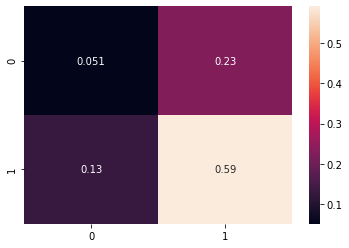

In [18]:
threshold = 0.65
y_pred = (prediction['prediction'] >= threshold).astype('int')
y_test = prediction[label]
print('threshold', threshold)
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [53]:
list_cols = [
    'Date', 'symbol',
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'label_next10_max', 'prediction'
]

prediction[list_cols].to_csv('./exported_data/au_prediction_crossValidation_20211007.csv', index=False)

In [71]:
kf = KFold(n_splits=5)

params = {'objective':'binary:logistic',
          'max_depth': 6, # default 6
          'alpha': 10,
          'gamma' : 0, # default 0
          'subsample' : 1, # default 1
          'colsample_bytree' : 1, # default 1
          'min_child_weight' : 1, # default 1
          'learning_rate': 0.1,
          'alpha' : 0, # default 0
          'eval_metric' : 'auc',
          'n_estimators' : 10000,
          'verbosity' : 1,
          'seed' : 10
         }    

models = []
for fold, (train_index, valid_index) in enumerate(kf.split(data_train_valid)):
    X_train = data_train_valid.iloc[train_index][list_cols_training]
    y_train = data_train_valid.iloc[train_index][label]
    
    X_valid = data_train_valid.iloc[valid_index][list_cols_training]
    y_valid = data_train_valid.iloc[valid_index][label]
    
    print('*' * 50)
    print(f'training with fold {fold}')
    
    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_metric="auc",
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=200,
              verbose=100)
     
    models.append(model)

**************************************************
training with fold 0


/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-auc:0.58704	validation_1-auc:0.58300
[100]	validation_0-auc:0.77865	validation_1-auc:0.76530
[200]	validation_0-auc:0.79545	validation_1-auc:0.77812
[300]	validation_0-auc:0.80560	validation_1-auc:0.78429
[400]	validation_0-auc:0.81415	validation_1-auc:0.78802
[500]	validation_0-auc:0.82161	validation_1-auc:0.79041
[600]	validation_0-auc:0.82796	validation_1-auc:0.79151
[700]	validation_0-auc:0.83386	validation_1-auc:0.79280
[800]	validation_0-auc:0.84000	validation_1-auc:0.79352
[900]	validation_0-auc:0.84564	validation_1-auc:0.79420
[1000]	validation_0-auc:0.85090	validation_1-auc:0.79498
[1100]	validation_0-auc:0.85580	validation_1-auc:0.79575
[1200]	validation_0-auc:0.86062	validation_1-auc:0.79612
[1300]	validation_0-auc:0.86525	validation_1-auc:0.79673
[1400]	validation_0-auc:0.86950	validation_1-auc:0.79704
[1500]	validation_0-auc:0.87419	validation_1-auc:0.79752
[1600]	validation_0-auc:0.87876	validation_1-auc:0.79791


KeyboardInterrupt: 

In [52]:
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44     41647
           1       0.54      0.60      0.57     48266

    accuracy                           0.52     89913
   macro avg       0.51      0.51      0.51     89913
weighted avg       0.51      0.52      0.51     89913



In [54]:
f1_score(y_test, y_pred)

0.5717630393294902

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

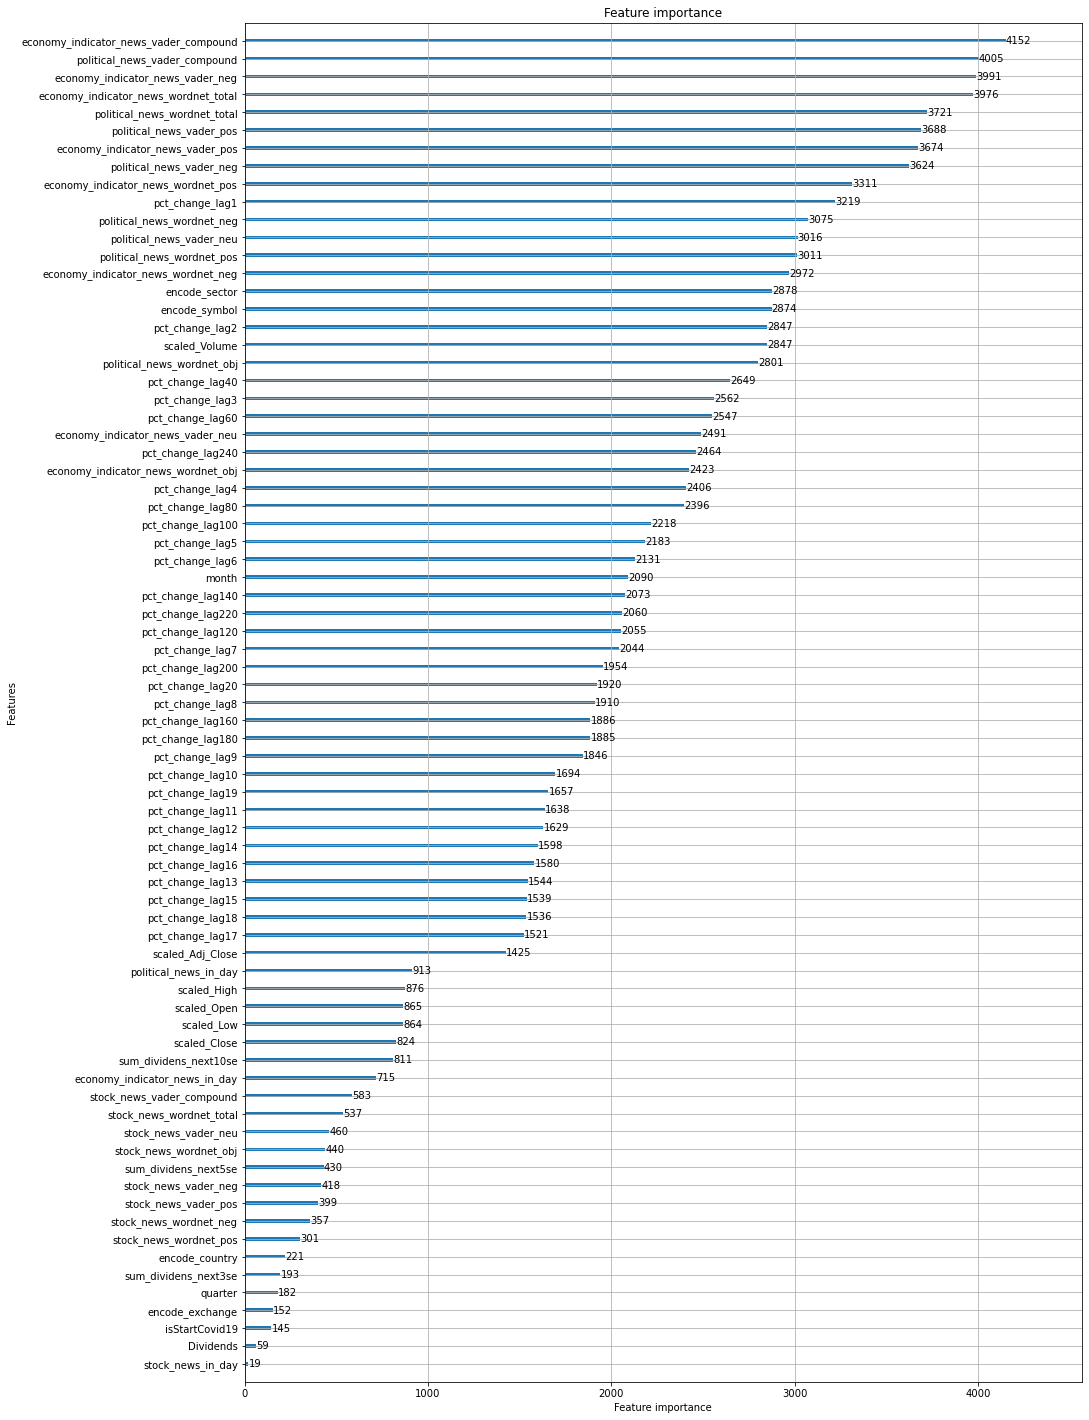

In [101]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

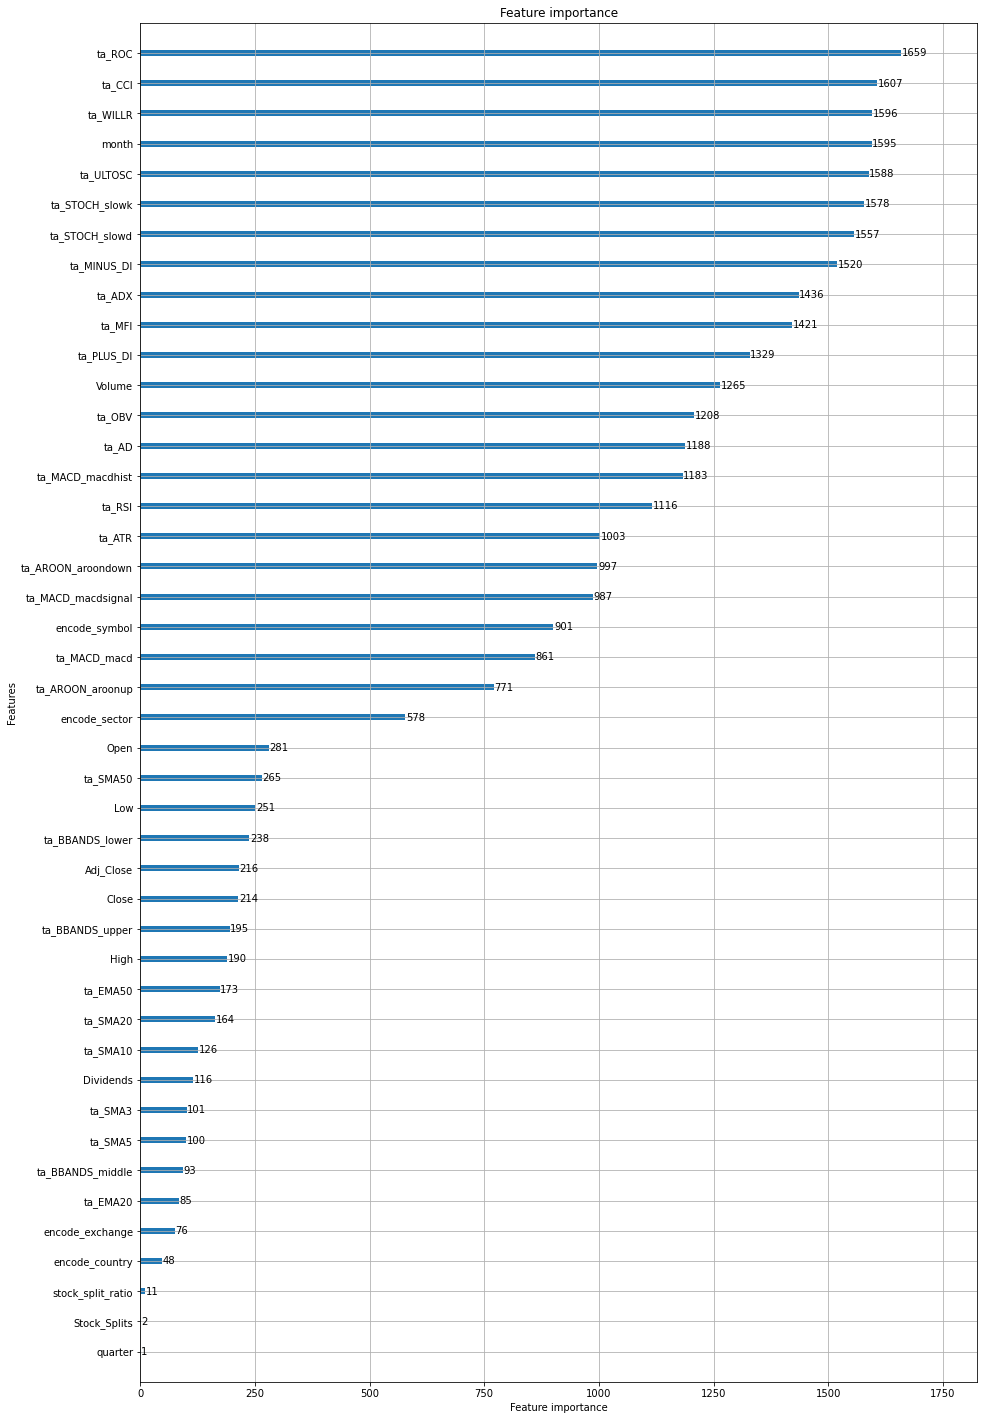

In [116]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

In [25]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [107]:
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 729499034766987098,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2229988788332758010
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3435331584
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 826412172484990487
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6285788610778399662
 physical_device_desc: "device: XLA_GPU device"]

In [ ]:
# X_train_val = data_train_valid[train_cols + ta_cols]
# y_train_val = data_train_valid[label]

In [93]:
X_train_ = np.expand_dims(X_train, 1)
y_train_ = y_train.values

In [94]:
X_train_.shape

(242449, 1, 117)

In [108]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=False))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

41201/41201 [==============================] - 99s 2ms/step - loss: 0.6529 - accuracy: 0.6373 - val_loss: 0.6922 - val_accuracy: 0.5637
Epoch 2/10
41201/41201 [==============================] - 99s 2ms/step - loss: 0.6499 - accuracy: 0.6374 - val_loss: 0.6881 - val_accuracy: 0.5637
Epoch 3/10
41201/41201 [==============================] - 99s 2ms/step - loss: 0.6491 - accuracy: 0.6375 - val_loss: 0.6929 - val_accuracy: 0.5637
Epoch 4/10
41201/41201 [==============================] - 96s 2ms/s

In [109]:
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

f1 score: 0.0
accuracy score: 0.6515519223400179
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     20404
           1       0.00      0.00      0.00     10912

    accuracy                           0.65     31316
   macro avg       0.33      0.50      0.39     31316
weighted avg       0.42      0.65      0.51     31316



/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

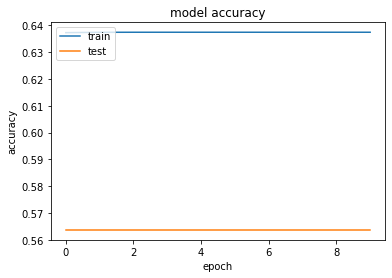

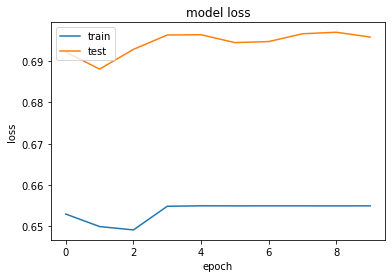

In [112]:
# summarize history for accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(CuDNNLSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='tanh'))

opt = tf.keras.optimizers.RMSprop(lr=7e-3)
model.compile(loss='mse',optimizer=opt, metrics=['mse'])
return model

In [26]:
X_train = np.expand_dims(X_train, 1)
y_train = y_train.values

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=256, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(1024, activation="relu"))
# model.add(tf.keras.layers.Dense(512, activation="relu"))
# model.add(tf.keras.layers.Dense(256, activation="relu"))
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001#, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=4)

Epoch 1/10


In [46]:
sector

'Technology'

In [54]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next3,label_t3,country,industry,sector,exchange,market,pct_change_lag1,pct_change_lag2,pct_change_lag3,pct_change_lag4,pct_change_lag5,pct_change_lag6,pct_change_lag7,pct_change_lag8,pct_change_lag9,pct_change_lag10,pct_change_lag11,pct_change_lag12,pct_change_lag13,pct_change_lag14,pct_change_lag15,pct_change_lag16,pct_change_lag17,pct_change_lag18,pct_change_lag19,pct_change_lag20,pct_change_lag21,pct_change_lag22,pct_change_lag23,pct_change_lag24,pct_change_lag25,pct_change_lag26,pct_change_lag27,pct_change_lag28,pct_change_lag29,pct_change_lag30,ext_features_close_pct_change_01,ext_features_close_pct_change_12,ext_features_close_pct_change_23,ext_features_close_pct_change_34,ext_features_close_pct_change_45,ext_features_high_open_00,ext_features_high_open_01,ext_features_high_open_02,ext_features_high_open_03,ext_features_high_open_04,ext_features_high_open_05,ext_features_high_open_11,ext_features_high_open_22,ext_features_high_open_33,ext_features_high_open_44,ext_features_high_open_55,ext_features_low_open_00,ext_features_low_open_11,ext_features_low_open_22,ext_features_low_open_33,ext_features_low_open_44,ext_features_low_open_55,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,month,quarter,scaled_Open,scaled_High,scaled_Low,scaled_Close,scaled_Adj Close,scaled_Volume,encode_sector,encode_country,encode_exchange,isStartCovid19,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total,economy_indicator_news_in_day,economy_indicator_news_vader_neg,economy_indicator_news_vader_pos,economy_indicator_news_vader_neu,economy_indicator_news_vader_compound,economy_indicator_news_wordnet_pos,economy_indicator_news_wordnet_neg,economy_indicator_news_wordnet_obj,economy_indicator_news_wordnet_total,stock_market_news_in_day,stock_market_news_vader_neg,stock_market_news_vader_pos,stock_market_news_vader_neu,stock_market_news_vader_compound,stock_market_news_wordnet_pos,stock_market_news_wordnet_neg,stock_market_news_wordnet_obj,stock_market_news_wordnet_total
7254,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.610315,302220800,AAPL,0.005374,0.027162,1,United States,Consumer Electronics,Technology,NASDAQ,us_market,0.015383,0.015082,0.021334,0.011561,0.019587,0.031815,0.037281,0.038591,0.075927,0.079287,0.085211,0.081643,0.057663,0.049484,0.044739,0.052655,0.056902,0.051874,0.046360,0.055248,0.060062,0.075955,0.101902,0.093348,0.131089,0.120548,0.092215,0.114414,0.096789,0.089611,0.015266,-0.000296,0.006140,-0.009615,0.007903,0.007544,0.022035,0.022308,0.013693,0.023052,0.031547,0.006841,0.005562,0.003337,0.014750,0.009710,-0.000978,-0.000050,-0.007190,-0.013734,-0.000199,-0.000501,0.002229,0.002228,0.002204,0.002223,0.002258,0.002206,0.002220,0.002176,0.002226,0.002238,-0.077995,-0.100807,0.051705,66.163947,72.080579,69.473305,63.463640,18.630647,16.340550,16.590612,35.509983,18.612016,-3.647316,0.918084,0.000768,62.404084,7.928729,14.285714,100.000000,1,1,0.002617,0.002630,0.002663,0.002633,0.002242,0.200662,9,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000
7255,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.678085,260022000,AAPL,0.011102,0.020051,1,

In [55]:
# data = df[df['sector'] == sector].copy().reset_index()
# data_train = data[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

In [124]:
sector = 'Technology'
data_pca = df[df['sector']==sector].copy().reset_index(drop=True)
data_train_pca = data_pca[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

In [ ]:

plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=vectorizer(y))

In [ ]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

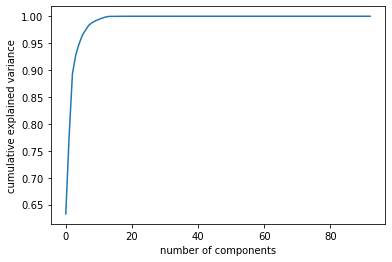

In [125]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [126]:
n_components = 10
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(data_train_pca)
print(f"Our reduced dimensions can explain {sum(pca.explained_variance_ratio_):.4f} % of the variance in the original data")

Our reduced dimensions can explain 0.9917 % of the variance in the original data


In [127]:
reducedDf = pd.DataFrame(data=principalComponents, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_pca['Date']
reducedDf['label_t3'] = data_pca['label_t3']
reducedDf.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-70.069784,3.749357,10.551597,-8.558242,-9.189304,-0.182206,-3.549381,-1.433659,0.030037,6.969359,2012-01-03,1
1,-78.891352,2.945219,5.337127,-6.165287,-3.686621,-3.314520,0.872366,-3.778433,1.939582,6.803152,2012-01-04,1
2,-93.493571,-4.953141,-0.557756,0.223312,3.611930,-6.892062,5.220530,-5.516167,3.665578,6.043418,2012-01-05,1
3,-100.003825,-9.987616,-1.092873,2.818413,11.203141,-9.525833,3.179822,-2.640966,5.327742,7.222354,2012-01-06,0
4,-92.775555,-3.078302,-0.142123,10.751203,16.950225,-9.317709,-1.096142,-0.927851,2.402696,7.612020,2012-01-09,0


In [ ]:
%%time
# sector = 'Technology'
n_components = 20

# data_tsne = df[df['sector']==sector].copy().reset_index(drop=True)
data_train_tnse = df[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

tsne = TSNE(n_components=n_components, perplexity=50, method='exact')
data_reduced_tsne = tsne.fit_transform(data_train_tnse)

reducedDf = pd.DataFrame(data=data_reduced_tsne, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_tsne['Date']
reducedDf['symbol'] = data_tsne['symbol']
reducedDf['label'] = data_tsne['label_t3']

In [128]:
train_date_start = '2010-01-01'
valid_date_start = '2020-06-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

data_train = reducedDf[(reducedDf["Date"] >= train_date_start) & (reducedDf["Date"] < valid_date_start)]
data_valid = reducedDf[(reducedDf["Date"] >= valid_date_start) & (reducedDf["Date"] < test_date_start)]
data_test = reducedDf[(reducedDf["Date"] >= test_date_start) & (reducedDf["Date"] <= test_date_end)]

data_train = shuffle(data_train).reset_index(drop=True)

In [129]:
print('train shape', data_train.shape)
print('valid shape', data_valid.shape)
# print('train valid shape', data_train_valid.shape)
print('test shape', data_test.shape)

print(f'valid ratio {data_valid.shape[0] / (data_valid.shape[0] + data_train.shape[0])}')

train shape (144442, 12)
valid shape (16472, 12)
test shape (4473, 12)
valid ratio 0.10236523857464236


In [130]:
data_train.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-46.055482,-26.309333,38.033506,3.976109,-6.616631,5.658540,6.479843,5.153382,-8.199018,2.640555,2019-06-25,1
1,-29.170939,25.468216,-2.823779,-30.592676,3.615985,-19.840973,7.042529,5.969284,-4.565430,-6.112230,2019-11-26,0
2,14.213304,42.096868,-0.599361,-8.958077,-0.210669,12.354283,-11.985723,-3.055317,-1.944377,-9.094315,2013-01-30,0
3,-24.655848,-23.515131,53.043560,-16.075260,-8.350646,7.923957,6.810792,-11.847214,-3.568611,-6.889425,2013-12-10,0
4,26.445225,-66.468305,-17.746687,-30.547832,8.182007,-0.675666,10.049485,5.526222,-0.097277,-2.083100,2016-01-22,0


In [131]:
X_train = data_train.drop(['Date', 'label_t3'], axis=1)
y_train = data_train['label_t3']

X_valid = data_valid.drop(['Date', 'label_t3'], axis=1)
y_valid = data_valid['label_t3']

X_test = data_test.drop(['Date', 'label_t3'], axis=1)
y_test = data_test['label_t3']

In [132]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_leaves": 50,
#     "max_bin": 32,
#     "feature_fraction": 0.6,
#     "bagging_fraction" : 0.6,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=10000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=20,
                  early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 54608, number of negative: 89834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 144442, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378062 -> initscore=-0.497783
[LightGBM] [Info] Start training from score -0.497783
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.661457	valid_1's binary_logloss: 0.689459
[40]	training's binary_logloss: 0.660212	valid_1's binary_logloss: 0.688749
[60]	training's binary_logloss: 0.659222	valid_1's binary_logloss: 0.688234
[80]	training's binary_logloss: 0.658387	valid_1's binary_logloss: 0.687805
[100]	training's binary_logloss: 0.657677	valid_1's binary_logloss: 0.687538
[120]	training's binary_logloss: 0.65706	valid_1's binary_l

In [140]:
threshold = 0.4
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f1_score(y_valid_pred, y_valid))
print(classification_report(y_valid, y_valid_pred))

0.3708562931863903
              precision    recall  f1-score   support

           0       0.59      0.77      0.67      9335
           1       0.49      0.30      0.37      7137

    accuracy                           0.56     16472
   macro avg       0.54      0.53      0.52     16472
weighted avg       0.55      0.56      0.54     16472



In [139]:
threshold = 0.4
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

0.3549295774647887
              precision    recall  f1-score   support

           0       0.60      0.69      0.64      2658
           1       0.41      0.31      0.35      1815

    accuracy                           0.54      4473
   macro avg       0.50      0.50      0.50      4473
weighted avg       0.52      0.54      0.53      4473



In [ ]:
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True)

In [135]:
df[(df['sector']=='Technology') & (df['Date']>='2021-01-01')].groupby('label_t3').size()

label_t3
0    6402
1    4461
dtype: int64

In [136]:
data_test.groupby('label_t3').size()

label_t3
0    2658
1    1815
dtype: int64

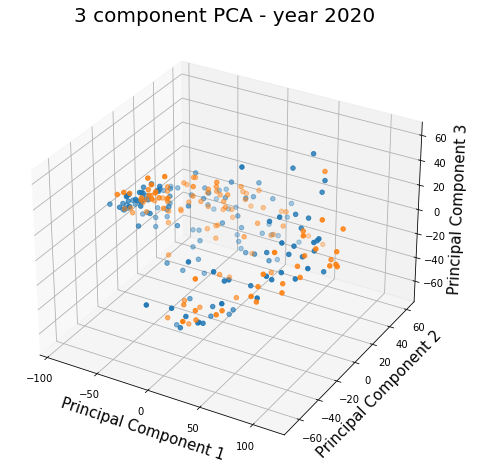

In [74]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

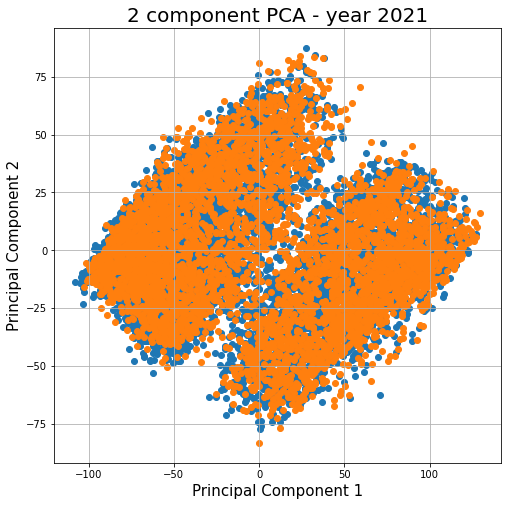

In [64]:
year = 2021
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'2 component PCA - year {year}', fontsize = 20)

ax.scatter(principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)

ax.scatter(principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)
# ax.legend(targets)
ax.grid()

In [63]:
s = pd.Series([1, 2, 3, 4, 5])
s

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [114]:
s.rolling(3).sum().shift(-3)

0     9.0
1    12.0
2     NaN
3     NaN
4     NaN
dtype: float64

In [67]:
s.rolling(3).apply(np.prod)

0     NaN
1     NaN
2     6.0
3    24.0
4    60.0
dtype: float64

In [47]:
help(talib.SMA)

Help on function SMA in module talib._ta_lib:

SMA(...)
    SMA(real[, timeperiod=?])
    
    Simple Moving Average (Overlap Studies)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 30
    Outputs:
        real



In [14]:
import matplotlib.pyplot as plt

In [47]:
close = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Adj Close']
high = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['High']
low = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Low']
# ta_SMA10 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA10']
# ta_SMA20 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA20']

# upper = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_upper']
# lower = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_lower']

# macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
ta_STOCH_slowk = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowk']
ta_STOCH_slowd = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowd']


slowk, slowd = talib.STOCH(high, low, close)

In [2]:
import ta

In [49]:
slowd - ta_STOCH_slowd

10100             NaN
10101             NaN
10102             NaN
10103             NaN
10104             NaN
10105             NaN
10106             NaN
10107             NaN
10108   -3.836931e-13
10109   -3.907985e-13
10110   -3.872458e-13
10111   -3.907985e-13
10112   -3.836931e-13
10113   -3.907985e-13
10114   -3.836931e-13
10115   -3.836931e-13
10116   -3.836931e-13
10117   -3.694822e-13
10118   -3.836931e-13
10119   -3.765876e-13
10120   -3.765876e-13
10121   -3.801404e-13
10122   -3.836931e-13
10123   -3.765876e-13
10124   -3.694822e-13
10125   -3.694822e-13
10126   -3.836931e-13
10127   -3.765876e-13
10128   -3.765876e-13
10129   -3.801404e-13
10130   -3.765876e-13
10131   -3.765876e-13
10132   -3.765876e-13
10133   -3.801404e-13
10134   -3.801404e-13
10135   -3.801404e-13
10136   -3.836931e-13
10137   -3.765876e-13
10138   -3.765876e-13
10139   -3.765876e-13
10140   -3.765876e-13
10141   -3.765876e-13
10142   -3.765876e-13
10143   -3.801404e-13
10144   -3.801404e-13
10145   -3

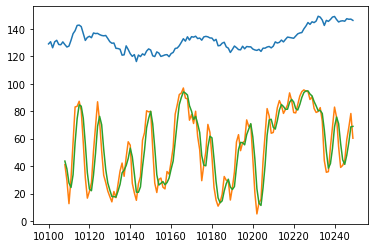

In [51]:
plt.plot(close, label='Closing Prices')
# plt.plot(rsi.values, label='rsi')
plt.plot(slowk, label='slowk')
plt.plot(slowd, label='slowd')
plt.show()

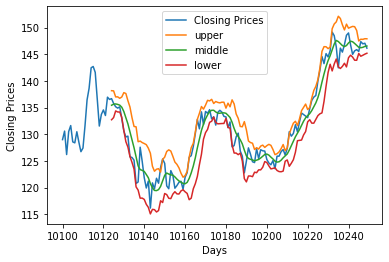

In [32]:
import matplotlib.pyplot as plt
# Plot the data
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(close, label='Closing Prices')
plt.plot(upper, label='upper')
plt.plot(middle, label='middle')
plt.plot(lower, label='lower')
plt.legend()
plt.show()

In [3]:
tmp = pd.DataFrame(np.random.random(100))

tmp['SMA'] = talib.SMA(tmp[0], timeperiod=10)
tmp['SMA2'] = ta.trend.sma_indicator(tmp[0], window=10)

tmp['delta'] = tmp['SMA']-tmp['SMA2']
tmp

,0,SMA,SMA2,delta
0,0.535400,NaN,NaN,NaN
1,0.277686,NaN,NaN,NaN
2,0.998812,NaN,NaN,NaN
3,0.025393,NaN,NaN,NaN
4,0.230199,NaN,NaN,NaN
5,0.400834,NaN,NaN,NaN
6,0.584140,NaN,NaN,NaN
7,0.280612,NaN,NaN,NaN
8,0.100513,NaN,NaN,NaN
9,0.368433,0.380202,0.380202,0.000000e+00


In [64]:
df

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,adj_close_lead,adjust_close_diff,label,stock_split_ratio,sum_dividens_next10se,sum_dividens_next5se,sum_dividens_next3se,ratio_stock_split_next10se,ratio_stock_split_next5se,ratio_stock_split_next3se,month,quarter,encode_symbol,encode_sector,encode_country,encode_exchange
3852,2015-03-16,A,41.160000,41.830002,41.110001,41.810001,39.410793,2551400.0,0.00,0.0,Healthcare,United States,NYSE,38.892348,38.696286,39.119521,39.280237,37.899021,38.903246,37.899021,39.495359,38.727775,37.960190,0.278070,0.423520,-0.145451,55.404715,52.373018,30.688019,47.488445,3965900.0,4.637804e+06,21.313331,22.283099,22.905749,-41.891883,-21.774436,0.700175,45.636802,-2.084317,92.857143,28.571429,39.193985,-0.216808,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3853,2015-03-17,A,41.520000,41.689999,41.060001,41.580002,39.193985,1504900.0,0.00,0.0,Healthcare,United States,NYSE,39.043168,38.875381,39.055422,39.330196,37.918250,38.930935,37.949804,39.508498,38.778795,38.049092,0.270770,0.392970,-0.122200,53.372139,68.312218,48.262883,40.042034,2461000.0,5.617197e+06,20.190756,20.575251,21.336993,-52.252217,-34.309733,0.703734,51.868161,-1.609107,85.714286,21.428571,39.702999,0.509014,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3854,2015-03-18,A,41.450001,42.380001,41.169998,42.119999,39.702999,1295600.0,0.00,0.0,Healthcare,United States,NYSE,39.435926,39.114806,39.066733,39.357532,37.961987,39.004465,38.018557,39.789289,38.927950,38.066610,0.302571,0.374890,-0.072320,57.330007,88.470232,69.718489,45.379175,3756600.0,6.356007e+06,17.818052,24.858604,20.991310,-27.928036,33.684487,0.739896,55.132998,0.285713,78.571429,14.285714,39.787838,0.084839,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3855,2015-03-19,A,42.049999,42.250000,41.820000,42.209999,39.787838,1085700.0,0.00,0.0,Healthcare,United States,NYSE,39.561607,39.324068,39.065791,39.407491,38.019110,39.079072,38.087940,40.036899,39.132660,38.228421,0.330805,0.366073,-0.035268,57.970363,85.932519,80.904989,50.754213,4842300.0,7.239711e+06,17.051198,23.788738,20.670319,-23.873978,65.886919,0.717761,64.347453,-0.023676,71.428571,7.142857,39.787838,-0.000000,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3856,2015-03-20,A,42.389999,42.529999,42.200001,42.209999,39.787838,2315500.0,0.00,0.0,Healthcare,United States,NYSE,39.759558,39.576691,39.129890,39.419745,38.066430,39.146574,38.154603,39.814506,39.341976,38.869446,0.349156,0.362690,-0.013533,57.970363,85.037594,86.480115,51.633493,4842300.0,5.064522e+06,16.465524,25.886019,20.782694,-17.561012,105.925682,0.690063,62.178001,1.637392,64.285714,0.000000,39.778408,-0.009430,0,1.0,0.1,0.1,0.0,1.0,1.0,1.0,3,1,0,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,2021-07-20,ZTS,197.240005,201.449997,197.240005,200.110001,200.110001,1884900.0,0.25,0.0,Healthcare,United States,NYSE,199.039215,199.626047,198.637976,193.339521,183.099781,193.926732,185.200231,202.546419,200.257493,197.968568,5.046538,5.037831,0.008707,72.130848,51.201952,57.261579,66.887439,278147700.0,1.933108e+08,12.645525,30.793608,46.941946,-11.725356,68.413181,2.985932,65.801650,3.269357,7.142857,71.428571,198.039993,-2.070007,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,7,3,496,6,5,1
2131,2021-07-21,ZTS,200.869995,200.869995,197.110001,198.039993,198.039993,1877600.0,0.00,0.0,Healthcare,United States,NYSE,198.576665,199.028918,198.726923,193.922313,183.641507,194.318471,185.703751,202.091330,200.027763,197.964197,4.

# Hypothesis Test using Random Forsest

In [32]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion="entropy")
rfc.fit(X_train, y_train)

<ipython-input-32-a94fb55c803a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_jobs=-1)

f1 score: 0.8106584992343032
accuracy score: 0.687998384980317
              precision    recall  f1-score   support

           0       0.25      0.07      0.11      2692
           1       0.73      0.92      0.81      7215

    accuracy                           0.69      9907
   macro avg       0.49      0.50      0.46      9907
weighted avg       0.60      0.69      0.62      9907



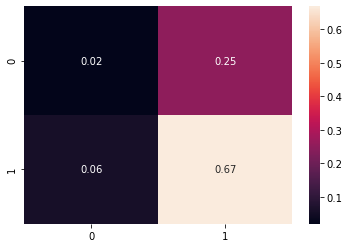

In [33]:
threshold = 0.6
y_pred = (rfc.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)